<h2 style='text-align: center;'>AIPM -  MiniProject - CH22M503</h2>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3>

### Problem - 1: Kalman Filter
###### Implement the Kalman Filter to estimate the level of water in the 4 tanks present in the Quadruple tank experiment, as discussed in class. The experiment is explained in detail in the reference paper (Quadruple tank process) as in the link given below.
    - Link: https://drive.google.com/file/d/1XQ-O1Rov4L_b6n1J6dJQ7_3cUy-l-ik4/view?usp=sharing
###### Please use the same parameter values as described in the paper. For the initial conditions, use the minimum-phase characteristic values. The transfer functions given in the paper can be ignored for this assignment. Q and R values have to be tuned to attain convergence of the filter and get better accuracy with the estimates. Tolerance, defined as the L2 norm between prior and posterior state vectors, has to be less than or equal to 5 X 10-3. Measurements are sampled at a time interval of 0.1s. Measurement values obtained by solving the model equations have also been uploaded in the link given below. Use them as the true measurements.
    - Link: https://docs.google.com/spreadsheets/d/10lm7KOxo6k3etXTsW5t2KYcC7d0sGUlZ/edit?usp=sharing&ouid=108491382124139074371&rtpof=true&sd=true

#### Importing Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Reference used 

In [2]:
# http://www.diva-portal.org/smash/get/diva2:495784/FULLTEXT01.pdf

#### Loading the data

In [3]:
# Load the data from an Excel file
tank_measurement_data = pd.read_excel('Link 2 Measurements.xlsx')
display(tank_measurement_data)

,h1,h2,h3,h4
0,12.400000,12.700000,1.800000,1.400000
1,12.404928,12.700618,1.792881,1.400301
2,12.409478,12.701239,1.786060,1.400592
3,12.413670,12.701863,1.779526,1.400873
4,12.417521,12.702490,1.773266,1.401145
...,...,...,...,...
9996,12.262968,12.783158,1.633941,1.409045
9997,12.262968,12.783158,1.633941,1.409045
9998,12.262968,12.783158,1.633941,1.409045
9999,12.262968,12.783158,1.633941,1.409045


#### Seperate each tank measurement 

In [4]:
# Separate the measurements for each tank
tank1_measurements = tank_measurement_data['h1'].values
tank2_measurements = tank_measurement_data['h2'].values
tank3_measurements = tank_measurement_data['h3'].values
tank4_measurements = tank_measurement_data['h4'].values

#### Display the result

In [5]:
print(tank1_measurements)
print(tank2_measurements)
print(tank3_measurements)
print(tank4_measurements)

[12.4        12.40492766 12.40947845 ... 12.26296752 12.26296752
 12.26296752]
[12.7        12.70061798 12.70123915 ... 12.7831584  12.7831584
 12.7831584 ]
[1.8        1.79288086 1.78606001 ... 1.63394113 1.63394113 1.63394113]
[1.4        1.40030108 1.40059211 ... 1.4090447  1.4090447  1.4090447 ]


#### Common variable declaration

In [6]:
# Create a time vector
time_steps = np.arange(len(tank1_measurements))
time_steps_10000 = np.arange(len(tank1_measurements) - 1)
# Measurements from the system
measurements = np.array([tank1_measurements, tank2_measurements, tank3_measurements, tank4_measurements]).T
# Variable holding the number of tanks for this excercise
num_tanks = measurements.shape[1]
# Variable to store the number of voltage source in the excercise
num_voltage_source = 2
# Number of measurement availables
num_measurements = len(measurements)
# Initialize lists to store values for plotting
X_post_list,X_prior_list,P_post_list,P_pri_list,Kalman_gain_list = [],[],[],[],[]
# Flag to track L2 norm convergence
l2_norm_converged = False  

#### Variable declaration for - Kalman Filter

In [7]:
# Simulation of Kalman Filter Based on The Quadruple-Tank Process: A Multivariable Laboratory Process with an Adjustable Zero
# Karl Henrik Johansson. Parameter Initialization

# Base variables required for further parameter initialization
h = tank_measurement_data.to_numpy()[0,:]
Ar = [28, 32, 28, 32]
ar = [0.071, 0.057, 0.071, 0.057]
g = 981.2
gamma_1, gamma_2= 0.7, 0.6
k1, k2 = 3.33, 3.35
kc=0.5

#Time constant measurement
T = [(Ar[i] / ar[i]) * np.sqrt((2 * h[i]) / g) for i in range(len(h))]
#State transtion matrix
state_transition_matrix = np.array([[-1 / T[0], 0, Ar[2] / (Ar[0] * T[2]), 0],
                                    [0, -1 / T[1], 0, Ar[3] / (Ar[1] * T[3])],
                                    [0, 0, -1 / T[2], 0], [0, 0, 0, -1 / T[3]]])
#Control input measurement
control_input = np.array([[3], [3]])
control_input_matrix = np.array([[(gamma_1 * k1) / Ar[0], 0], [0, (gamma_2 * k2) / Ar[1]],
                                 [0, ((1 - gamma_2) * k2) / Ar[2]], [((1 - gamma_1) * k1) / Ar[3], 0]])
# Initial state estimate
initial_state = np.ones((num_tanks, 1)) 
# Initial error covariance
initial_error_covariance = 1e5 * np.eye(num_tanks)  
# Measurement noise covariance - Hyperparameter
measurement_noise_cov_init = 2 * np.eye(num_voltage_source) 
#Observation Matrix
observation_matrix = np.array([[kc, 0, 0, 0], [0, kc, 0, 0]])
#Process Noise covariance
process_noise_cov_init = 10 * np.eye(num_tanks)
# Time step - This can also be modified according to your needs
delta_t = 0.1

#Print Statements
print(f'Initial Value: \n {h}')
print(f'Time Constant : \n{T}')
print(f'state_transition_matrix :\n{state_transition_matrix}')
print(f'control_input_matrix :\n{control_input_matrix}')
print(f'initial_state :\n{initial_state.T}')
print(f'observation_matrix :\n{observation_matrix}')
print(f'initial_error_covariance :\n{initial_error_covariance}')
print(f'measurement_noise_cov :\n{measurement_noise_cov_init}')
print(f'process_noise_cov_init :\n{process_noise_cov_init}')

Initial Value: 
 [12.4 12.7  1.8  1.4]
Time Constant : 
[62.69699892820124, 90.32609002462239, 23.887580479237094, 29.989924232904087]
state_transition_matrix :
[[-0.01594973  0.          0.04186276  0.        ]
 [ 0.         -0.011071    0.          0.03334453]
 [ 0.          0.         -0.04186276  0.        ]
 [ 0.          0.          0.         -0.03334453]]
control_input_matrix :
[[0.08325    0.        ]
 [0.         0.0628125 ]
 [0.         0.04785714]
 [0.03121875 0.        ]]
initial_state :
[[1. 1. 1. 1.]]
observation_matrix :
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]]
initial_error_covariance :
[[100000.      0.      0.      0.]
 [     0. 100000.      0.      0.]
 [     0.      0. 100000.      0.]
 [     0.      0.      0. 100000.]]
measurement_noise_cov :
[[2. 0.]
 [0. 2.]]
process_noise_cov_init :
[[10.  0.  0.  0.]
 [ 0. 10.  0.  0.]
 [ 0.  0. 10.  0.]
 [ 0.  0.  0. 10.]]


#### Common function

In [8]:
def kalman_filter_simulation_1stVersion(z, u, A, B, H, Q, R, P, x): 
    """
    Simulates a Kalman filter given the measurements and system parameters.Follow only the explanation as per class
    but found some issue in unit of different measured value

    Args:
        z (numpy.ndarray): Array of shape (num_measurements, num_features) containing the measurements.
        u (numpy.ndarray): Array of shape (num_measurements, num_inputs) containing the control inputs.
        A (numpy.ndarray): System dynamics matrix of shape (num_features, num_features).
        B (numpy.ndarray): Control matrix of shape (num_features, num_inputs).
        H (numpy.ndarray): Observation Measurement matrix of shape (num_measurements, num_features).
        Q (numpy.ndarray): Process noise covariance matrix of shape (num_features, num_features).
        R (numpy.ndarray): Measurement noise covariance matrix of shape (num_measurements, num_measurements).
        P (numpy.ndarray): Initial state covariance matrix of shape (num_features, num_features).
        x (numpy.ndarray): Initial state vector of shape (num_features,).

    Returns:
        Tuple: A tuple containing lists of estimated states, post-measurement state covariances,
        prior-measurement state covariances, Kalman gains and measurement error

    """
    # Number of measurements
    num_measurements = len(z)
    l2_norm_converged = False  # Flag to track L2 norm convergence
    X_post_list,X_prior_list,P_post_list,P_pri_list,Kalman_gain_list, measurement_error_list = [],[],[],[],[],[]
    for k in range(num_measurements):
        # Prediction step
        X_pri = np.dot(A, x) + np.dot(B, u[:].reshape(-1, 1)) # Prior state estimate
        P_pri = np.dot(np.dot(A, P), A.T) + Q # Prior state covariance
        X_prior_list.append(X_pri.flatten()) # Store prior state estimate  
        
        # Update step
        K = np.dot(np.dot(P_pri, H.T), np.linalg.inv(np.dot(np.dot(H, P_pri), H.T) + R)) # Kalman gain
        Z_est = np.dot(H, X_pri) # Estimated measurement        
        E = z[k,:2] - Z_est.flatten() # Measurement error         
        
        measurement_error_list.append(E) # List of measurement error
        initial_state = X_pri + np.dot(K, E.reshape(-1, 1)) # Updated state estimate
        P = P_pri - np.dot(np.dot(K, H), P_pri) # Updated state covariance
        x = initial_state # Updated the initial states
        
        # Append values to the lists
        X_post_list.append(initial_state.flatten()) # Store post-measurement state estimate
        P_post_list.append(np.diag(P)) # Store post-measurement state covariance
        P_pri_list.append(np.diag(P_pri)) # Store prior-measurement state covariance
        Kalman_gain_list.append(np.trace(K)) # Store Kalman gain
        
        # Calculate the L2 norm        
        l2_norm = np.linalg.norm(X_pri - initial_state)
        threshold = 5e-3
        l2_norm_converged = False
        
        if np.allclose(l2_norm, threshold) and not l2_norm_converged:
            print(f"L2 norm converges to threshold value at {k} iteration")
            l2_norm_converged = True
            break
    
    estimated_states = initial_state.flatten()  # Final estimated states
    print("Posterior states:", estimated_states)      
    # Return simulation results
    return X_post_list, X_prior_list, P_post_list, P_pri_list, Kalman_gain_list, measurement_error_list

def kalman_filter_simulation_2ndVersion(Z, h0, A, B, H, U, Q, R, delta_t): 
    """
    Simulates a Kalman filter given the measurements and system parameters. Updated this as per the confluence 
    of research paper statement as well as concept taught in class keeping the unit measurement into consideration
    for each measured value.
    Args:
        Z (numpy.ndarray): The true state data.
        h0 (numpy.ndarray): Initial state vector of shape (num_features,).
        A (numpy.ndarray): System dynamics matrix of shape (num_features, num_features).
        B (numpy.ndarray): Control matrix of shape (num_features, num_inputs).
        H (numpy.ndarray): Observation Measurement matrix of shape (num_measurements, num_features).
        U (numpy.ndarray): Array of shape (num_measurements, num_inputs) containing the control inputs.
        Q (numpy.ndarray): Process noise covariance matrix of shape (num_features, num_features).
        R (numpy.ndarray): Measurement noise covariance matrix of shape (num_measurements, num_measurements).
        delta_t (float): Time step for each iteration.
    Returns:
        Tuple: A tuple containing lists of estimated states, post-measurement state covariances,
        prior-measurement state covariances, Kalman gains and measurement error
    """
    X_post_init = Z[1, :4].reshape(-1, 1)
    P_posterior_0 = 1e5 * np.eye(4)
    X_posterior_store, X_prior_store, P_posterior_store, P_prior_store, Kalman_Gain_store, Innovation_store, Residue_store = [], [], [], [], [], [], []
    
    for iteration in range(Z.shape[0] - 1):
        
        # Calculate the measurement prediction V_i
        V_i = H.dot(Z[iteration+1, :4].reshape(-1, 1))
        
        # Calculate the prior state estimate X_prior
        X_pri = (A.dot(X_post_init - h0) + B.dot(V_i - U)) * delta_t
        X_pri += h0
        
        # Update h0 for the next iteration
        h0 = Z[iteration+1, :4].reshape(-1, 1)
        
        # Calculate the prior state covariance P_prior
        P_pri = (A.dot(P_posterior_0).dot(A.T) + Q) * (delta_t ** 2)
        
        # Calculate the Kalman gain
        K = (P_pri.dot(H.T)).dot(np.linalg.inv((H.dot(P_pri)).dot(H.T) + R))
        
        # Calculate the true measurement
        V_true = H.dot(Z[iteration, :4].reshape(-1, 1))
        
        # Calculate the innovation or measurement residual
        E = V_true - H.dot(X_pri)
        
        # Calculate the posterior state estimate X_posterior
        X_posterior = X_pri + K.dot(E)
        
        # Calculate the posterior state covariance P_posterior
        P = P_pri - (K.dot(H)).dot(P_pri)
        
        # Store the calculated values
        X_posterior_store.append(X_posterior.tolist())
        P_posterior_store.append(np.diag(P))
        X_prior_store.append(X_pri.tolist())
        P_prior_store.append(np.diag(P_pri))
        Kalman_Gain_store.append(np.trace(K))
        Innovation_store.append(E.tolist())
        Residue_store.append((Z[iteration, :2].reshape(-1, 1) - H.dot(X_posterior)).tolist())
        
        # Update the initial state and covariance for the next iteration
        X_post_init = X_posterior
        P_posterior_0 = P
        
        # Check convergence based on the L2 norm of X_prior and X_posterior
        l2_norm = np.linalg.norm((X_pri - X_posterior), 2)
        threshold = 5e-3
        l2_norm_converged = False
        if np.allclose(l2_norm, threshold) and not l2_norm_converged:
            print(f"L2 norm converges to threshold value at {iteration} iteration")
            l2_norm_converged = True
            break
            
    # Calculate the mean estimation for each tank
    mean_estimation = [np.mean(X_posterior[i]) for i in range(num_tanks)]    
    print(f"Estimation Tank 1: {mean_estimation[0]}\nEstimation Tank 2: {mean_estimation[1]}\nEstimation Tank 3: {mean_estimation[2]}\nEstimation Tank 4: {mean_estimation[3]}")
    
    # Return the stored values
    return X_posterior_store, X_prior_store, P_posterior_store, P_prior_store, Kalman_Gain_store, Innovation_store, Residue_store


def plot_filterwise_tank_data(subplot_num, time_steps, original_data, filter_results, tank_measurements, tank_name, marker):
    """
    Plots the tank data for a specific filter.

    Parameters:
        subplot_num (int): The subplot number for the current tank.
        time_steps (numpy.ndarray): Array of time steps.
        original_data (numpy.ndarray): Array of original tank data.
        filter_results (numpy.ndarray): Array of filter results for the current tank.
        tank_measurements (numpy.ndarray): Array of tank measurements for the current tank.
        tank_name (str): Name of the current tank.
        marker (str): Marking the tank wise plot

    Returns:
        None
    """
    # Create a subplot for the current tank
    plt.subplot(2, 2, subplot_num) 
    # Plot the original tank data
    plt.scatter(time_steps, original_data, label='Original Data', color='#9A0EEA', s = 55, marker = 'v')  
    # Plot the filter results
    plt.scatter(time_steps, filter_results, label='Filter Results', color='red', marker = '*')  
    # Plot the tank measurements
    plt.scatter(time_steps, tank_measurements, label='Measurements', color='#76FF7B', marker=marker, s = 30) 
    # Set the x-axis label
    plt.xlabel('Time Steps')  
    # Set the y-axis label
    plt.ylabel('Tank Level') 
    # Set the title for the subplot
    plt.title(tank_name)  
    # Show the legend
    plt.legend()
    
def plotSingularData(subplot_num, time_steps, data, marker, ylable, color):
    """
    Plot a singular dataset on a subplot within a figure.

    Parameters:
        subplot_num (int): The number of the subplot where the data will be plotted.
        time_steps (array-like): The time steps corresponding to the data points.
        data (array-like): The data to be plotted.
        marker (str): The marker style for the data points.
        ylable (str): The label for the y-axis.
        color (str): The color for the data line and marker.

    Returns:
        None
    """
    # Defining the plot figure size
    plt.figure(figsize=(9, 5))
    # Adding the plot sup title 
    plt.suptitle(ylable, fontsize='20')
    # Create a subplot for the current tank
    plt.subplot(1, 1, subplot_num) 
    plt.plot(time_steps, data, label=ylable, color=color, marker=marker) 
    # Set the x-axis label
    plt.xlabel('Time Steps')  
    # Set the y-axis label
    plt.ylabel(ylable) 
    # Show the legend
    plt.legend()

def plotGraphicalData(subplot_num, time_steps, data, marker, ylabel, color, SupTitle, Legend):
    """
    Plot a multiple dataset on a subplot within a figure.

    Parameters:
        subplot_num (int): The number of the subplot where the data will be plotted.
        time_steps (array-like): The time steps corresponding to the data points.
        data (array-like): The data to be plotted.
        marker (str): The marker style for the data points.
        ylabel (str): The label for the y-axis.
        color (str): The color for the data line and marker.
        SupTitle : The suptitle of the plot
        Legend : The legend information
    Returns:
        None
    """
    # Defining the plot figure size
    plt.figure(figsize=(9, 5))
    # Adding the plot sup title 
    plt.suptitle(SupTitle, fontsize='20')
    # Create a subplot for the current tank
    plt.subplot(1, 1, subplot_num)
    if len(data) > 1:
         for i in range(len(data)):
            plt.plot(time_steps, data[i], label=Legend[i], color=color[i], marker=marker[i])
            plt.ylabel(ylabel[i])
    else:
        plt.plot(time_steps, data, label= Legend[0], color=color, marker=marker)
    # Set the x-axis label
    plt.xlabel('Time Steps')
    # Show the legend
    plt.legend()

def plot_data(subplot_num, posterior, prior, tank_name, posterior_color='blue', prior_color='orange', subplotdim = 2):
    """
    Plot the posterior and prior data.

    Args:
        subplot_num (int): Subplot number for the current plot.
        posterior (list): List containing the posterior data.
        prior (list): List containing the prior data.
        tank_name (str): Contain the name of Tank
        posterior_color (str): Color of the posterior data points. Defaults to 'blue'.
        prior_color (str): Color of the prior data points. Defaults to 'orange'.
    """
    cum_data = []
    for i in range(min(len(posterior), len(prior))):
        cum_data.append(posterior[i])
        cum_data.append(prior[i])

    # Create a subplot for the current tank
    plt.subplot(subplotdim, subplotdim, subplot_num)
    plt.plot(cum_data, color=posterior_color, label='Prior - Posterior Combined')
    plt.xlabel('Time Steps')
    plt.ylabel('Prior & Posterior Value')
    plt.title(f'Posterior and Prior Plot for {tank_name}')
    plt.legend()
    plt.xlim(0, len(cum_data)-1)


<h2 style='text-align: center;'>Kalman Filter - 1st Approach</h2>

#### Looping through different combination of constant value to multiply with process noise covariance to see the best convergence for estimation

In [9]:
for hyperparameter in range(1,11,1):
    process_noise_cov = hyperparameter * np.eye(num_tanks)  # Process noise covariance     
    print(f'hyperparameter value {hyperparameter}')
    X_post_list_loop, X_prior_list_loop, _, _, _, _ = kalman_filter_simulation_1stVersion(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov, measurement_noise_cov_init, initial_error_covariance, initial_state)

hyperparameter value 1
Posterior states: [2.91549207 2.98449633 0.13324816 0.08759252]
hyperparameter value 2
Posterior states: [5.05249697 5.22493903 0.12959493 0.08515466]
hyperparameter value 3
Posterior states: [6.80483577 7.06091302 0.1265995  0.08315699]
hyperparameter value 4
Posterior states: [8.26780509 8.59288435 0.12409885 0.08149015]
hyperparameter value 5
Posterior states: [9.50762158 9.8905888  0.12197974 0.08007824]
hyperparameter value 6
Posterior states: [10.57172888 11.00394729  0.12016102  0.07886693]
hyperparameter value 7
Posterior states: [11.49501064 11.96963713  0.11858304  0.0778163 ]
hyperparameter value 8
Posterior states: [12.30368913 12.81521076  0.11720097  0.07689637]
hyperparameter value 9
Posterior states: [13.01785649 13.56176738  0.11598046  0.07608417]
hyperparameter value 10
Posterior states: [13.6531672  14.22573778  0.11489474  0.07536183]


##### Explanation on choosing the process noise covariance value: 
- I have been tuning the hyperparameters to improve the accuracy of the estimation. Among the various hyperparameter values tested, a value of 8 has shown promising results, providing estimations that are close to the real values.

- Based on this observation, I have utilized this hyperparameter value as a multiplier term for the process noise covariance matrix. This modification aims to adjust the uncertainty in the system dynamics, considering the estimates of all four tanks.

#### Calling Kalman filter function for estimation with new process noise covariance matrix

In [10]:
process_noise_cov = 8 * np.eye(num_tanks)  # Process noise covariance
print(f'process_noise_cov : {process_noise_cov}')
X_post_list_loop, X_prior_list_loop, P_post_list_loop, P_pri_list_loop, Kalman_gain_list_loop, Measurement_error_loop = kalman_filter_simulation_1stVersion(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov, measurement_noise_cov_init, initial_error_covariance, initial_state)

process_noise_cov : [[8. 0. 0. 0.]
 [0. 8. 0. 0.]
 [0. 0. 8. 0.]
 [0. 0. 0. 8.]]
Posterior states: [12.30368913 12.81521076  0.11720097  0.07689637]


In [11]:
X_post_list_loop = np.array(X_post_list_loop)
X_prior_list_loop = np.array(X_prior_list_loop)
P_post_list_loop = np.array(P_post_list_loop)
P_pri_list_loop = np.array(P_pri_list_loop)
Kalman_gain_list_loop = np.array(Kalman_gain_list_loop)

In [12]:
print(f'Tank 1 : Prior Estimate : {np.mean(X_prior_list_loop[:, 0] + h[0])}')
print(f'Tank 2 : Prior Estimate : {np.mean(X_prior_list_loop[:, 1] + h[1])}')
print(f'Tank 3 : Prior Estimate : {np.mean(X_prior_list_loop[:, 2] + h[2])}')
print(f'Tank 4 : Prior Estimate : {np.mean(X_prior_list_loop[:, 3] + h[3])}')

Tank 1 : Prior Estimate : 12.45830972770082
Tank 2 : Prior Estimate : 12.749072750727205
Tank 3 : Prior Estimate : 1.9387416703642066
Tank 4 : Prior Estimate : 1.4911540726631718


##### Based on the Quadruple-Tank Process: A Multivariable Laboratory Process with an Adjustable Zero Karl Henrik Johansson. Parameter Initialization


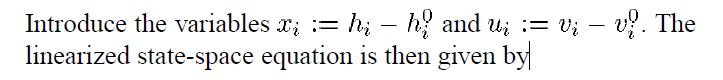

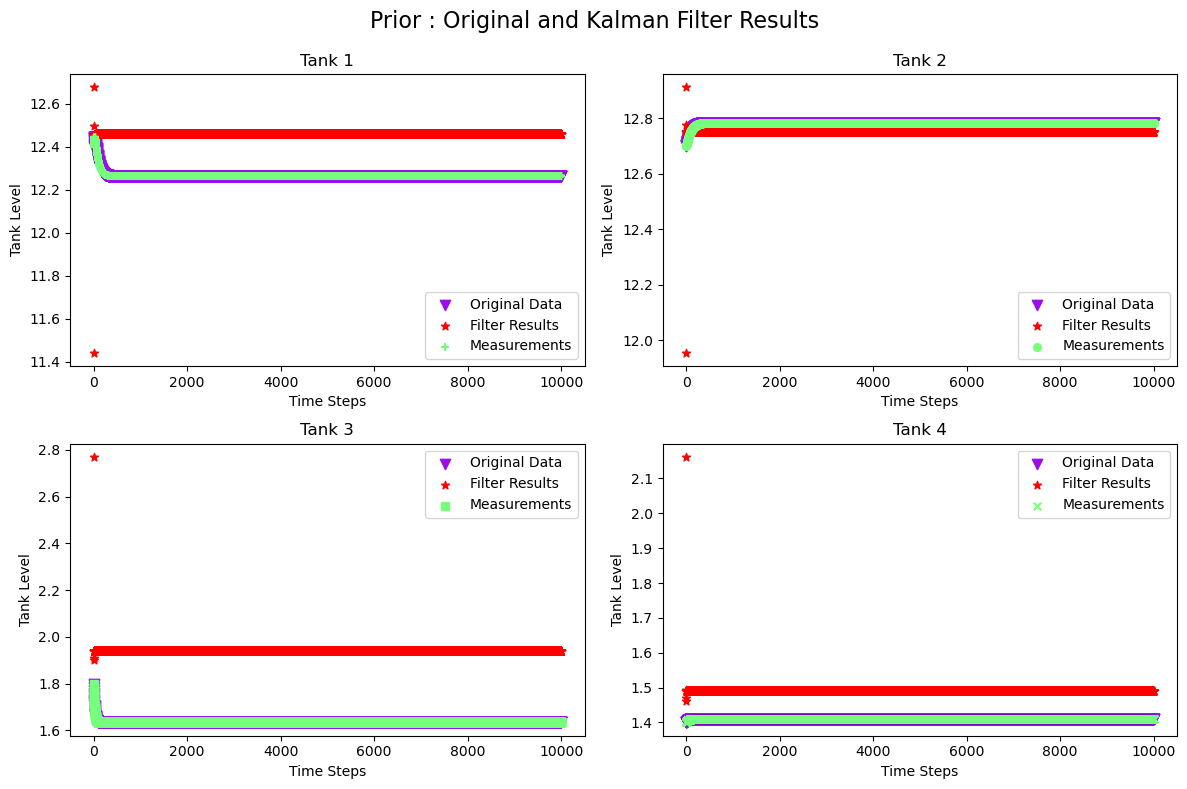

In [129]:
# Initialize the plot for Prior : Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Prior : Original and Kalman Filter Results', fontsize=16)

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_prior_list_loop[:, 0] + h[0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_prior_list_loop[:, 1] + h[1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_prior_list_loop[:, 2] + h[2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_prior_list_loop[:, 3] + h[3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [14]:
print(f'Tank 1 : Posterior Estimate : {np.mean(X_post_list_loop[:, 0])}')
print(f'Tank 2 : Posterior Estimate : {np.mean(X_post_list_loop[:, 1])}')
print(f'Tank 3 : Posterior Estimate : {np.mean(X_post_list_loop[:, 2])}')
print(f'Tank 4 : Posterior Estimate : {np.mean(X_post_list_loop[:, 3])}')

Tank 1 : Posterior Estimate : 12.306672148185898
Tank 2 : Posterior Estimate : 12.815466187393067
Tank 3 : Posterior Estimate : 0.11528296679472223
Tank 4 : Posterior Estimate : 0.0749478076157384


###### Posterior plots with entire data

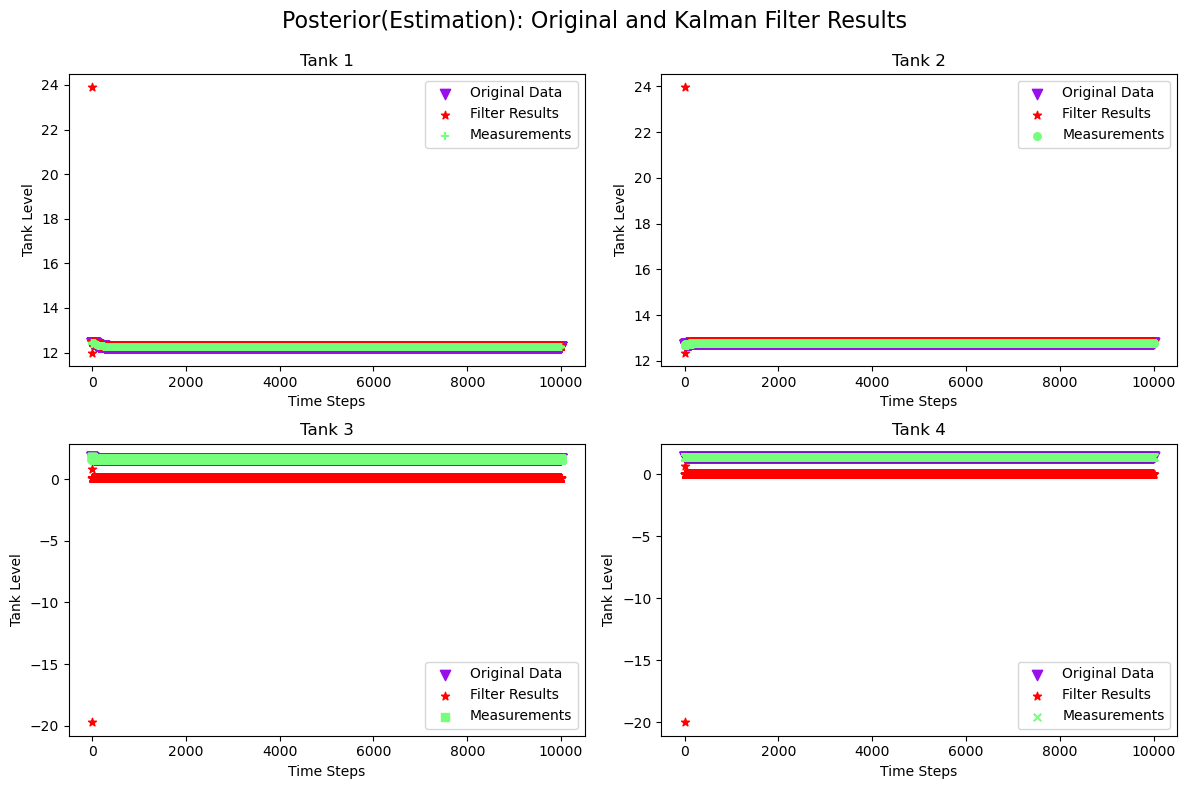

In [130]:
# Initialize the plot for Posterior(Estimation): Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior(Estimation): Original and Kalman Filter Results', fontsize=16)

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_post_list_loop[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_post_list_loop[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_post_list_loop[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_post_list_loop[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Posterior plot after removing the first measurement to visualize the variation much closely

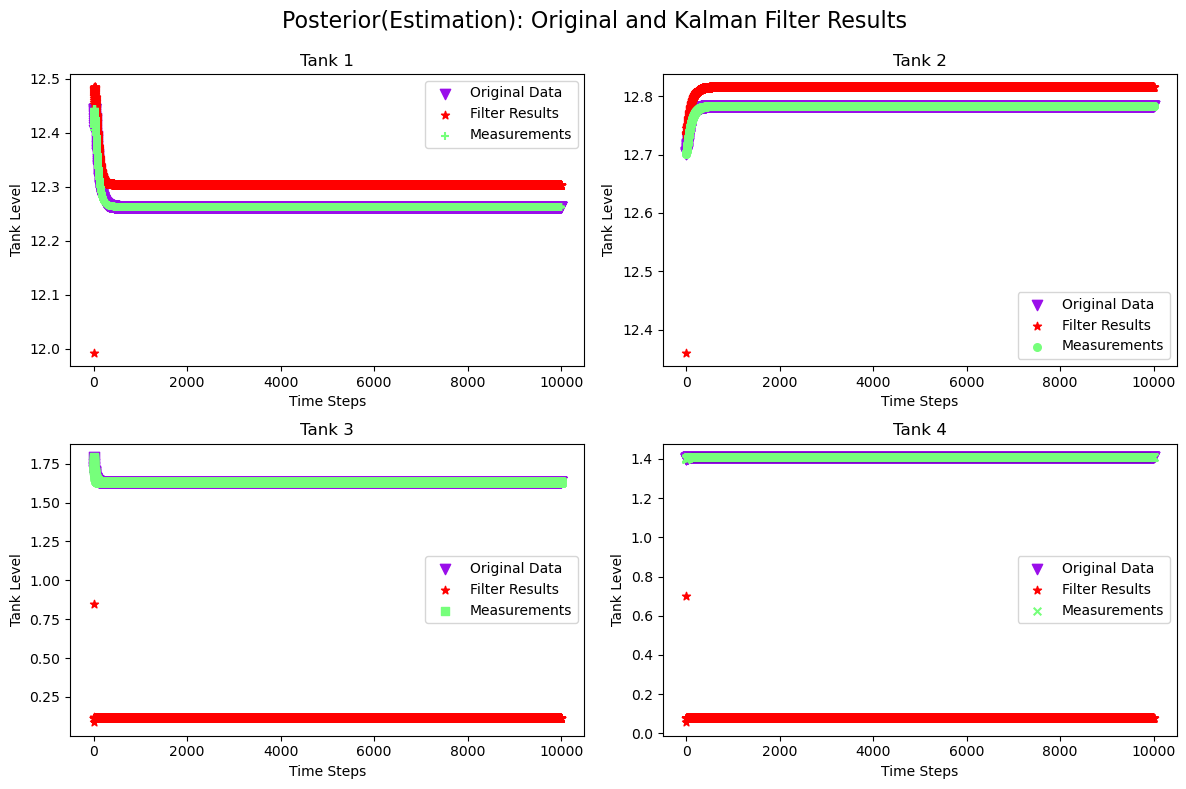

In [131]:
# Initialize the plot for Posterior(Estimation): Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior(Estimation): Original and Kalman Filter Results', fontsize=16)

plot_filterwise_tank_data(1, time_steps_10000, tank1_measurements[1:], X_post_list_loop[1:, 0], tank1_measurements[1:], 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps_10000, tank2_measurements[1:], X_post_list_loop[1:, 1], tank2_measurements[1:], 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps_10000, tank3_measurements[1:], X_post_list_loop[1:, 2], tank3_measurements[1:], 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps_10000, tank4_measurements[1:], X_post_list_loop[1:, 3], tank4_measurements[1:], 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Conclusion based upon the graphical result arrived after tuning the process noise covariance value : 
- However, upon analyzing the results from the above plotted graph, it has become evident that while the selected hyperparameter value of 8 produces accurate estimations for Tank 1 and Tank 2, it does not yield satisfactory results for Tank 3 and Tank 4. Therefore, further verification and optimization steps are required to improve the estimation accuracy for these particular tanks.

- The next steps involve examining the underlying dynamics of Tank 3 and Tank 4 more closely. By analyzing their behavior and identifying potential sources of discrepancy, we can refine the hyperparameter selection and modify the process noise covariance matrix accordingly. This iterative process aims to optimize the estimation performance of the Kalman filter for all four tanks in the 4 tank classic problem.

##### To improve the accuracy of the posterior estimation specifically for Tank 3 and Tank 4, I have made slight modifications to the process noise covariance matrix as follows,

- The intuition behind this modification is based on the fact that interconnected relationship of each tank. By considering this interconnectedness, I have updated the corresponding positions in the process noise covariance matrix. Instead of assigning a value of 0, I have assigned a value of 1.

- By doing so, the Kalman filter is empowered to make use of this information during the estimation process. It strives to bring the estimations of Tank 3 and Tank 4 closer to their actual values, in addition to the estimations for Tank 1 and Tank 2.

- This adjustment allows for a more sophisticated estimation approach, taking into account the interconnected nature of the tanks. As a result, the overall estimation accuracy and reliability of the Kalman filter for the 4 tank  problem are enhanced.

In [17]:
process_noise_cov_updated = 8 * np.eye(num_tanks)
process_noise_cov_updated[2,1] = process_noise_cov_updated[3, 0] = process_noise_cov_updated[0,3] = process_noise_cov_updated[1,2] = process_noise_cov_updated[2,2] = process_noise_cov_updated[3,3] = 1
print(f'process_noise_cov : {process_noise_cov_updated}')
X_post_list_loop_Q, X_prior_list_loop_Q, P_post_list_loop_Q, P_pri_list_loop_Q, Kalman_gain_list_loop_Q, Measurement_error_loop_Q = kalman_filter_simulation_1stVersion(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov_updated, measurement_noise_cov_init, initial_error_covariance, initial_state)

process_noise_cov : [[8. 0. 0. 1.]
 [0. 8. 1. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 1.]]
Posterior states: [12.32599798 12.83327561  1.66342392  1.56520151]


In [18]:
X_post_list_loop_Q = np.array(X_post_list_loop_Q)
X_prior_list_loop_Q = np.array(X_prior_list_loop_Q)
P_post_list_loop_Q = np.array(P_post_list_loop_Q)
P_pri_list_loop_Q = np.array(P_pri_list_loop_Q)
Kalman_gain_list_loop_Q = np.array(Kalman_gain_list_loop_Q)


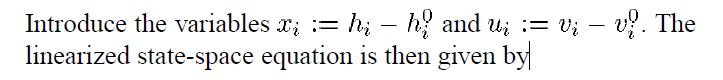

In [19]:
print(f'Tank 1 : Prior Estimate : {np.mean(X_prior_list_loop_Q[:, 0] + h[0])}')
print(f'Tank 2 : Prior Estimate : {np.mean(X_prior_list_loop_Q[:, 1] + h[1])}')
print(f'Tank 3 : Prior Estimate : {np.mean(X_prior_list_loop_Q[:, 2] + h[2])}')
print(f'Tank 4 : Prior Estimate : {np.mean(X_prior_list_loop_Q[:, 3] + h[3])}')

Tank 1 : Prior Estimate : 12.522667371056746
Tank 2 : Prior Estimate : 12.7984980114899
Tank 3 : Prior Estimate : 1.874028371863514
Tank 4 : Prior Estimate : 1.4415288311863206


###### Prior plots with entire data

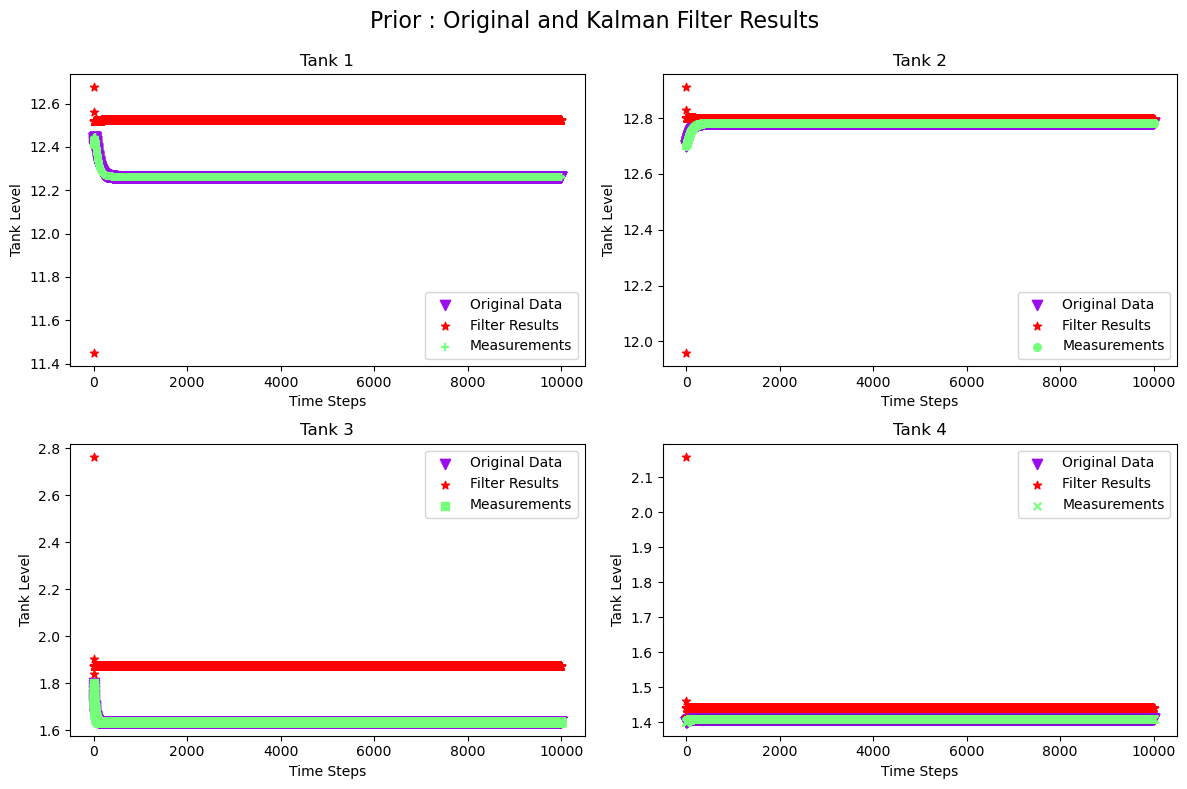

In [132]:
# Initialize the plot for Prior : Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Prior : Original and Kalman Filter Results', fontsize=16)

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_prior_list_loop_Q[:, 0] + h[0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_prior_list_loop_Q[:, 1] + h[1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_prior_list_loop_Q[:, 2] + h[2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_prior_list_loop_Q[:, 3] + h[3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [21]:
print(f'Tank 1 : Posterior Estimate : {np.mean(X_post_list_loop_Q[:, 0])}')
print(f'Tank 2 : Posterior Estimate : {np.mean(X_post_list_loop_Q[:, 1])}')
print(f'Tank 3 : Posterior Estimate : {np.mean(X_post_list_loop_Q[:, 2])}')
print(f'Tank 4 : Posterior Estimate : {np.mean(X_post_list_loop_Q[:, 3])}')

Tank 1 : Posterior Estimate : 12.328972889077397
Tank 2 : Posterior Estimate : 12.83353146968779
Tank 3 : Posterior Estimate : 1.6612816996404474
Tank 4 : Posterior Estimate : 1.5633538551789496


###### Posterior plots with entire data

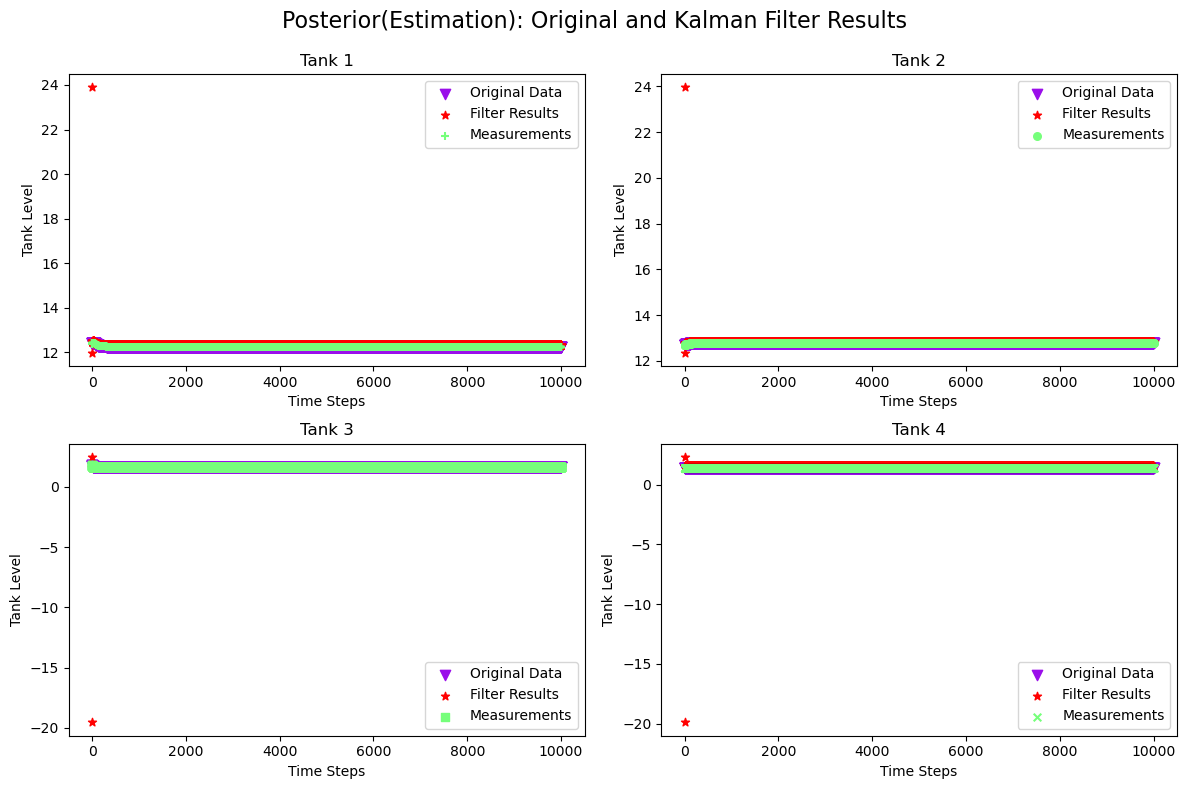

In [133]:
# Initialize the plot for Posterior(Estimation): Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior(Estimation): Original and Kalman Filter Results', fontsize=16)

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_post_list_loop_Q[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_post_list_loop_Q[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_post_list_loop_Q[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_post_list_loop_Q[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Posterior plot after removing the first measurement to visualize the variation much closely

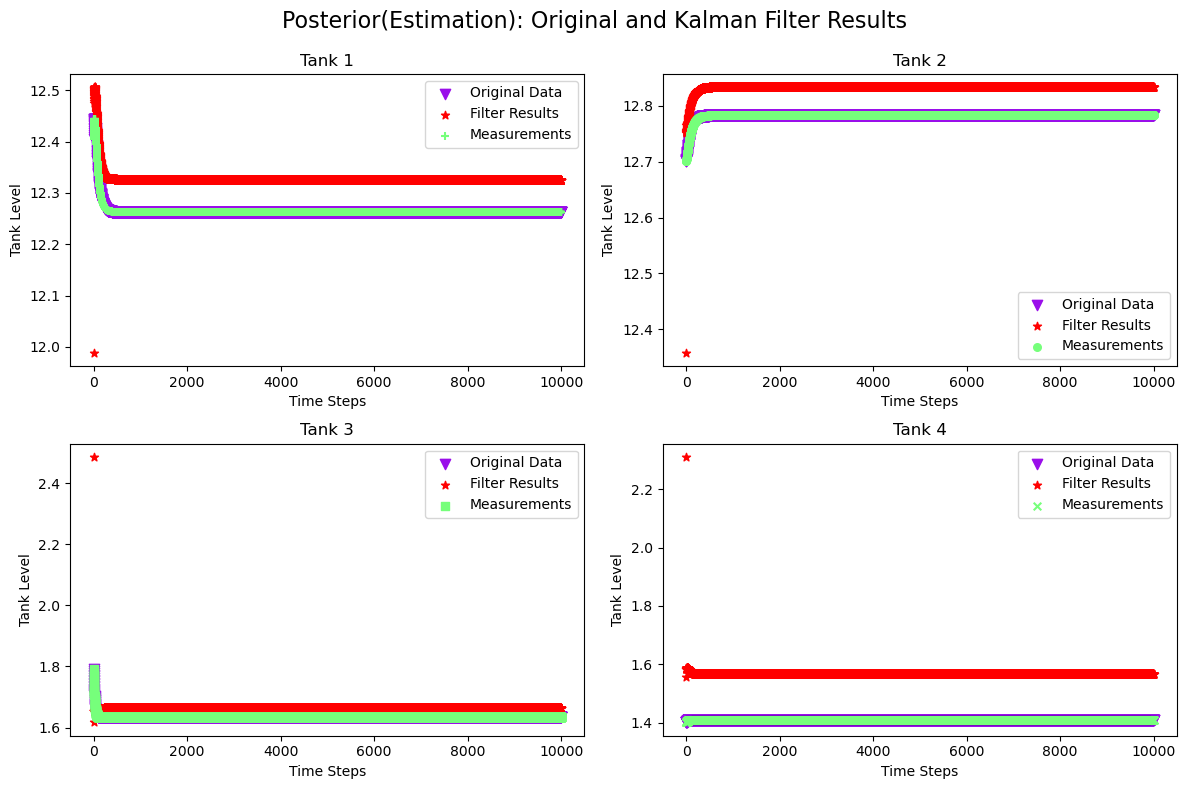

In [134]:
# Initialize the plot for Posterior(Estimation): Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior(Estimation): Original and Kalman Filter Results', fontsize=16)

plot_filterwise_tank_data(1, time_steps_10000, tank1_measurements[1:], X_post_list_loop_Q[1:, 0], tank1_measurements[1:], 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps_10000, tank2_measurements[1:], X_post_list_loop_Q[1:, 1], tank2_measurements[1:], 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps_10000, tank3_measurements[1:], X_post_list_loop_Q[1:, 2], tank3_measurements[1:], 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps_10000, tank4_measurements[1:], X_post_list_loop_Q[1:, 3], tank4_measurements[1:], 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Conclusion based upon the graphical result arrived after applying the new process noise covariance value : 
- Upon reviewing the posterior plot of the 4-tank implementation of the Kalman filter, it is evident that in the previous setup, satisfactory results were achieved only for Tank 1 and Tank 2. However, in the subsequent modification, significant improvements were observed in the estimation accuracy for Tank 3 and Tank 4 over the course of 10,000 timesteps. This enhancement demonstrates the effectiveness of the updated process noise covariance matrix [[8. 0. 0. 1.], [0. 8. 1. 0.], [0. 1. 1. 0.], [1. 0. 0. 1.]]. 

##### Different graphical plots for Kalman Filter using 1st Approach

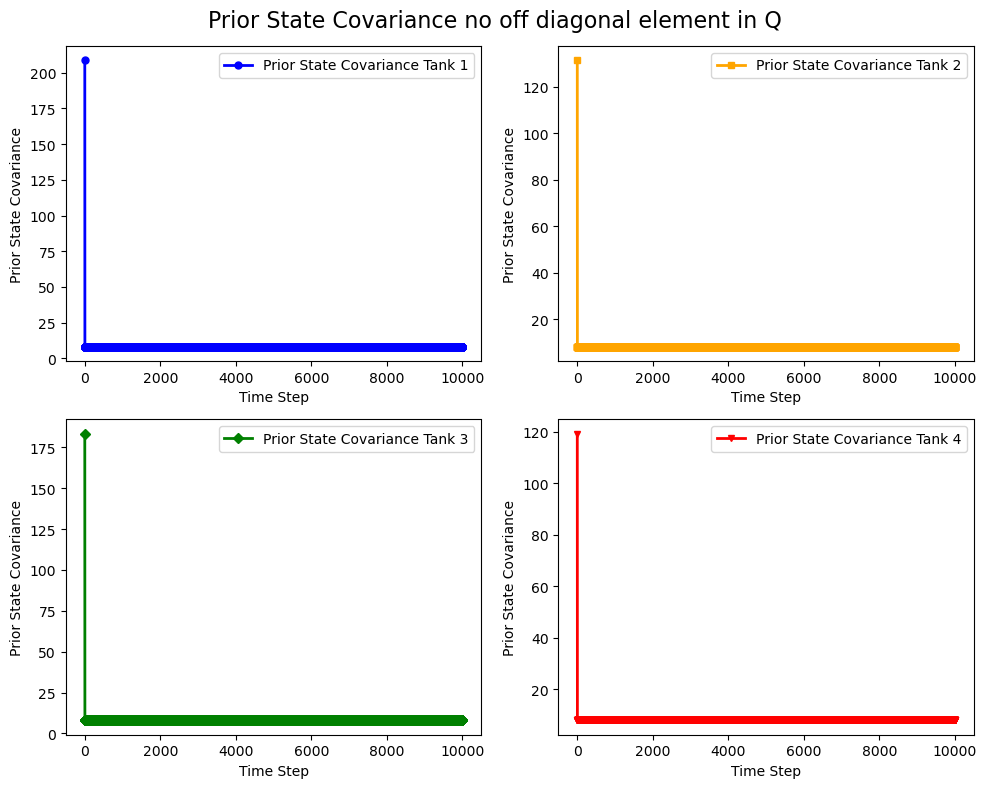

In [92]:
# Initialize the figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Define colors for the lines
colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 's', 'D', 'v']

# Iterate over each column of P_pri_list_loop and create a separate plot
for i, ax in enumerate(axs.flat):
    ax.plot(P_pri_list_loop[:, i], color=colors[i], marker=markers[i], markersize=5, linewidth=2)
    ax.set_ylabel(f'Prior State Covariance')
    ax.set_xlabel('Time Step')
    ax.legend([f'Prior State Covariance Tank {i+1}'], loc='upper right')

# Set the overall title for the figure
fig.suptitle('Prior State Covariance no off diagonal element in Q', fontsize=16)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

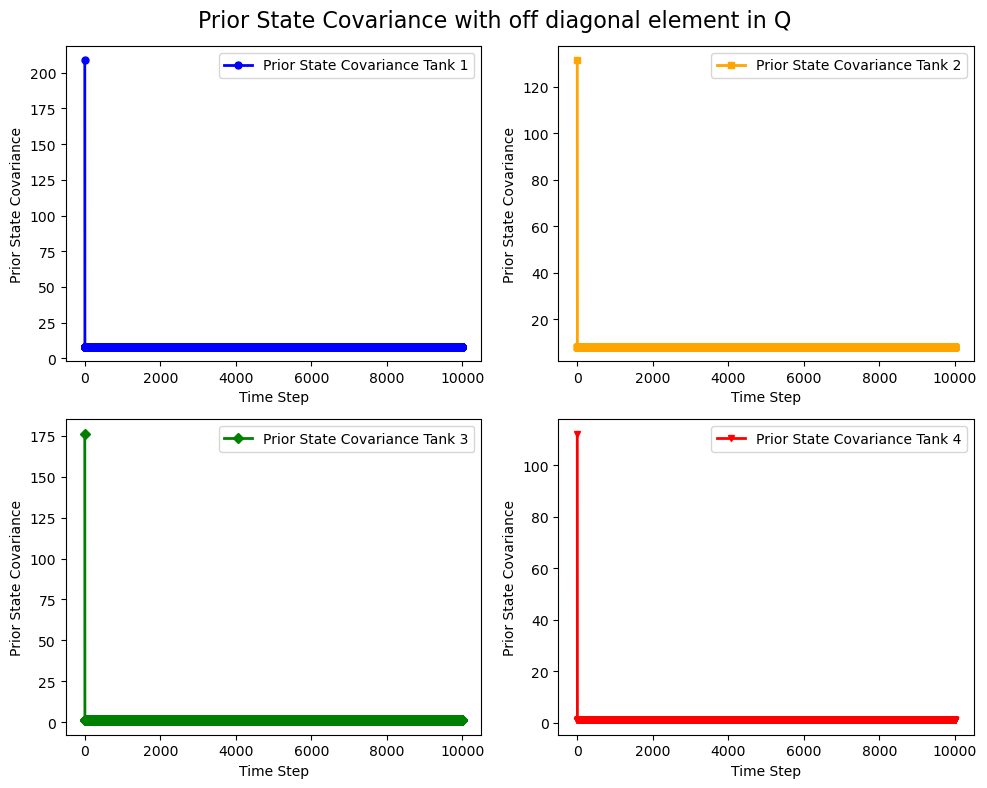

In [121]:
# Initialize the figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Define colors for the lines
colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 's', 'D', 'v']

# Iterate over each column of P_pri_list_loop and create a separate plot
for i, ax in enumerate(axs.flat):
    ax.plot(P_pri_list_loop_Q[:, i], color=colors[i], marker=markers[i], markersize=5, linewidth=2)
    ax.set_ylabel(f'Prior State Covariance')
    ax.set_xlabel('Time Step')
    ax.legend([f'Prior State Covariance Tank {i+1}'], loc='upper right')

# Set the overall title for the figure
fig.suptitle('Prior State Covariance with off diagonal element in Q', fontsize=16)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

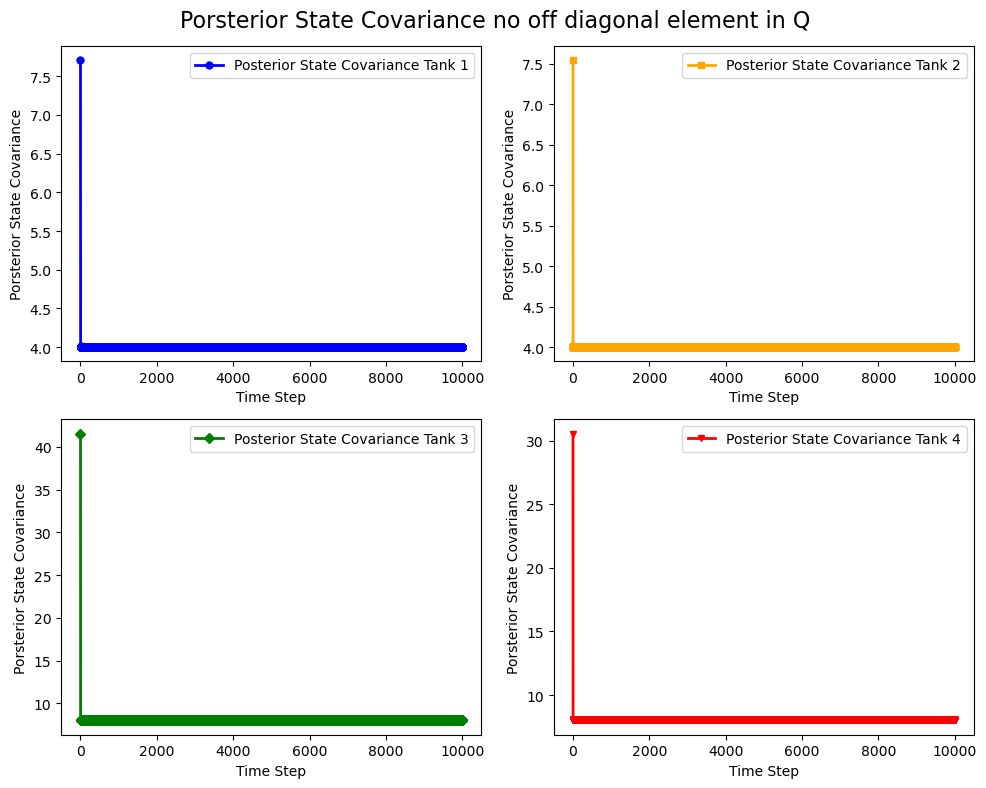

In [96]:
# Initialize the figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Define colors for the lines
colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 's', 'D', 'v']

# Iterate over each column of P_pri_list_loop and create a separate plot
for i, ax in enumerate(axs.flat):
    ax.plot(P_post_list_loop[:, i], color=colors[i], marker=markers[i], markersize=5, linewidth=2)
    ax.set_ylabel(f'Porsterior State Covariance')
    ax.set_xlabel('Time Step')
    ax.legend([f'Posterior State Covariance Tank {i+1}'], loc='upper right')

# Set the overall title for the figure
fig.suptitle('Porsterior State Covariance no off diagonal element in Q', fontsize=16)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

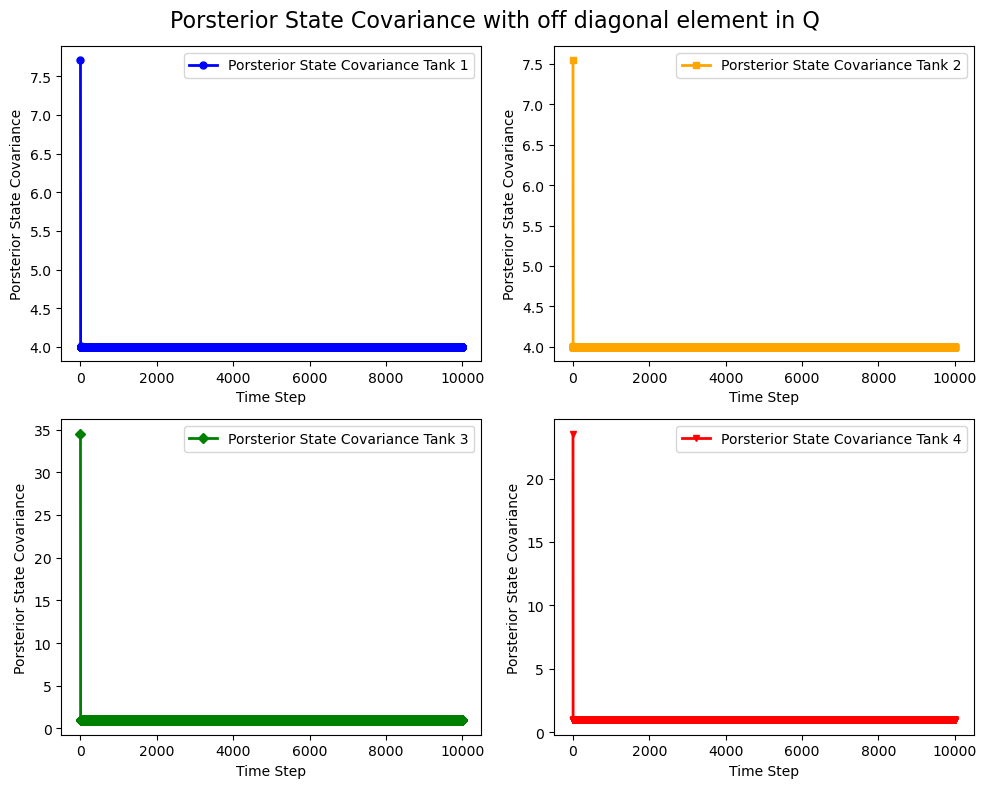

In [122]:
# Initialize the figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

plt.suptitle
# Define colors for the lines
colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 's', 'D', 'v']

# Iterate over each column of P_pri_list_loop and create a separate plot
for i, ax in enumerate(axs.flat):
    ax.plot(P_post_list_loop_Q[:, i], color=colors[i], marker=markers[i], markersize=5, linewidth=2)
    ax.set_ylabel(f'Porsterior State Covariance')
    ax.set_xlabel('Time Step')
    ax.legend([f'Porsterior State Covariance Tank {i+1}'], loc='upper right')

# Set the overall title for the figure
fig.suptitle('Porsterior State Covariance with off diagonal element in Q', fontsize=16)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

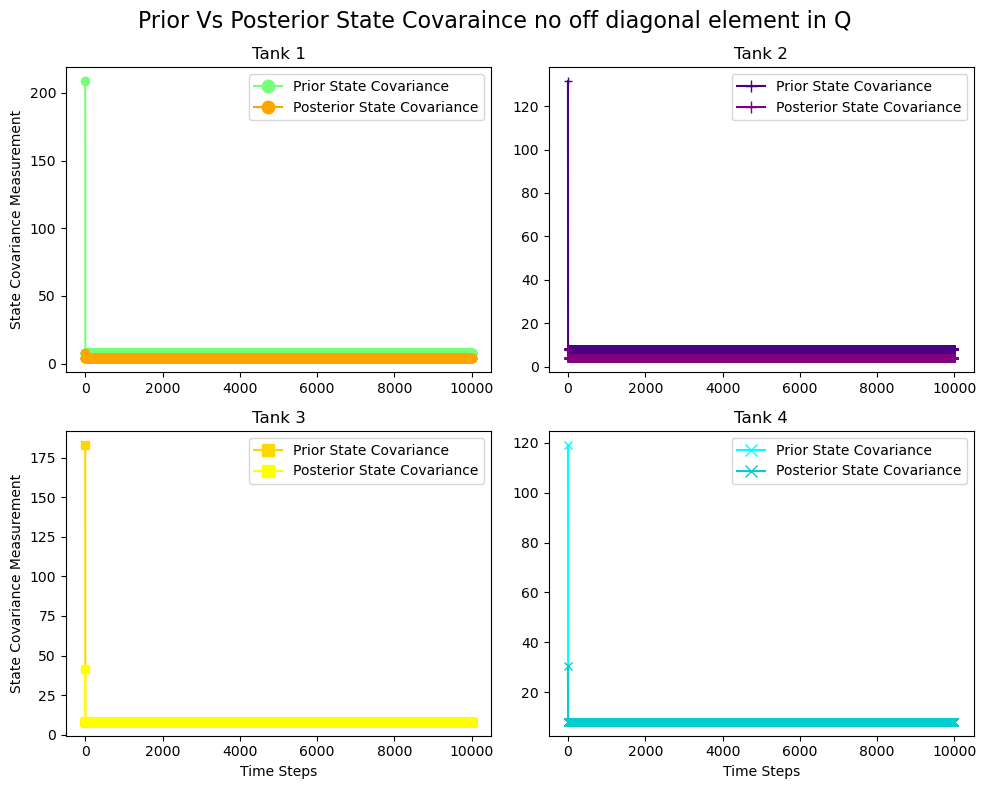

In [106]:
# Define colors and markers for the plots
prior_colors = ['#76FF7B', '#4B0082', '#FFD700', '#00FFFF']
posterior_colors = ['#FFA500', '#800080', '#FFFF00', '#00CED1']
markers = ['o', '+', 's', 'x']

# Create a 2x2 grid layout for the plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Prior Vs Posterior State Covaraince no off diagonal element in Q', fontsize=16)
# Iterate over the tanks and create plots in the grid layout
for i, ax in enumerate(axs.flat):
    # Plot Prior State Covariance
    ax.plot(time_steps, P_pri_list_loop[:, i], label='Prior State Covariance', color=prior_colors[i], marker=markers[i])
    
    # Plot Posterior State Covariance
    ax.plot(time_steps, P_post_list_loop[:, i], label='Posterior State Covariance', color=posterior_colors[i], marker=markers[i])
    
    # Set title for each subplot
    ax.set_title(f'Tank {i+1}')
    
    # Set x-axis label for the last row of subplots
    if i >= 2:
        ax.set_xlabel('Time Steps')
    
    # Set y-axis label for the first and third column of subplots
    if i % 2 == 0:
        ax.set_ylabel('State Covariance Measurement')
    
    # Show the legend for each subplot
    ax.legend(loc='upper right')

    # Add marker to the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', markerscale=1.5)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plots
plt.show()

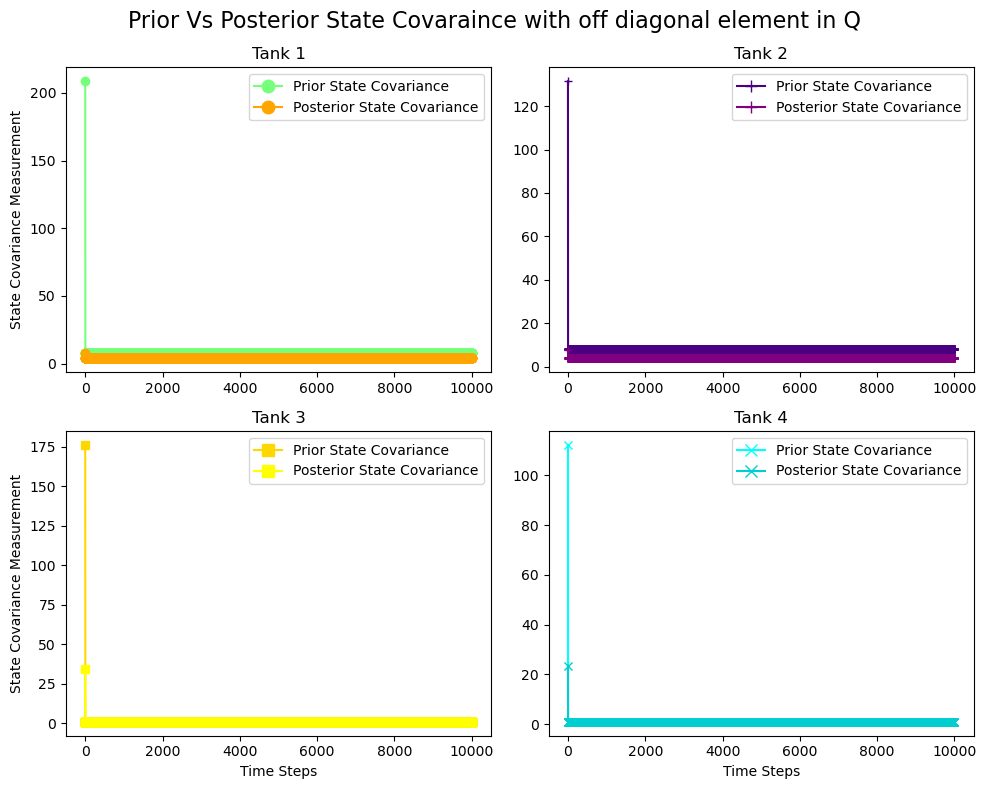

In [107]:
# Define colors and markers for the plots
prior_colors = ['#76FF7B', '#4B0082', '#FFD700', '#00FFFF']
posterior_colors = ['#FFA500', '#800080', '#FFFF00', '#00CED1']
markers = ['o', '+', 's', 'x']

# Create a 2x2 grid layout for the plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Prior Vs Posterior State Covaraince with off diagonal element in Q', fontsize=16)
# Iterate over the tanks and create plots in the grid layout
for i, ax in enumerate(axs.flat):
    # Plot Prior State Covariance
    ax.plot(time_steps, P_pri_list_loop_Q[:, i], label='Prior State Covariance', color=prior_colors[i], marker=markers[i])
    
    # Plot Posterior State Covariance
    ax.plot(time_steps, P_post_list_loop_Q[:, i], label='Posterior State Covariance', color=posterior_colors[i], marker=markers[i])
    
    # Set title for each subplot
    ax.set_title(f'Tank {i+1}')
    
    # Set x-axis label for the last row of subplots
    if i >= 2:
        ax.set_xlabel('Time Steps')
    
    # Set y-axis label for the first and third column of subplots
    if i % 2 == 0:
        ax.set_ylabel('State Covariance Measurement')
    
    # Show the legend for each subplot
    ax.legend(loc='upper right')

    # Add marker to the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', markerscale=1.5)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plots
plt.show()

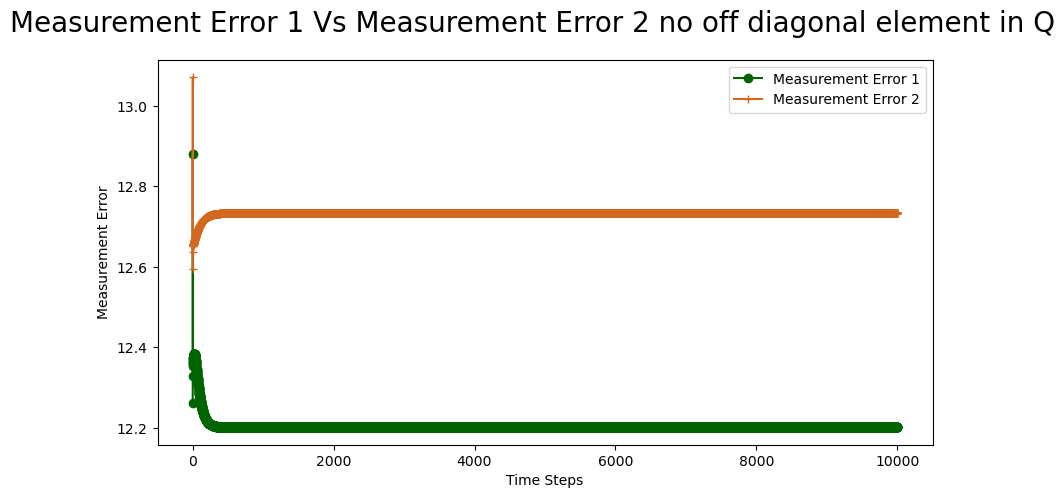

In [30]:
plt.figure(figsize=(10, 5))
plt.suptitle('Measurement Error 1 Vs Measurement Error 2 no off diagonal element in Q', fontsize = '20')
# Create a subplot for the current tank
plt.subplot(1, 1, 1) 
plt.plot(time_steps, np.array(Measurement_error_loop_Q)[:,0], label='Measurement Error 1', color='#006400', marker='o') 
plt.plot(time_steps, np.array(Measurement_error_loop_Q)[:,1], label='Measurement Error 2', color='#D2691E', marker='+') 
# Set the x-axis label
plt.xlabel('Time Steps')  
# Set the y-axis label
plt.ylabel('Measurement Error') 
# Show the legend
plt.legend()
plt.show()

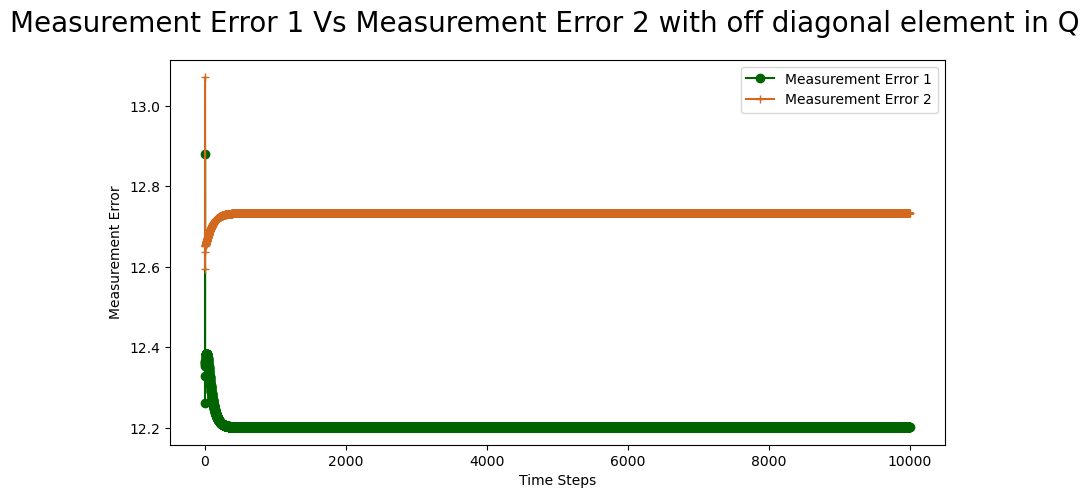

In [31]:
plt.figure(figsize=(10, 5))
plt.suptitle('Measurement Error 1 Vs Measurement Error 2 with off diagonal element in Q', fontsize = '20')
# Create a subplot for the current tank
plt.subplot(1, 1, 1) 
plt.plot(time_steps, np.array(Measurement_error_loop_Q)[:,0], label='Measurement Error 1', color='#006400', marker='o') 
plt.plot(time_steps, np.array(Measurement_error_loop_Q)[:,1], label='Measurement Error 2', color='#D2691E', marker='+') 
# Set the x-axis label
plt.xlabel('Time Steps')  
# Set the y-axis label
plt.ylabel('Measurement Error') 
# Show the legend
plt.legend()
plt.show()

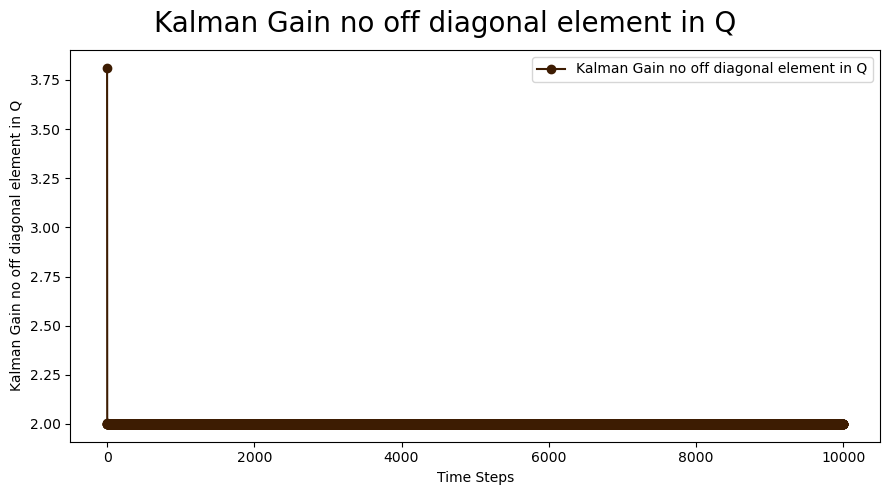

In [32]:
# Initialize the plot for Kalman gain 
plotSingularData(1, time_steps, Kalman_gain_list_loop_Q, 'o', 'Kalman Gain no off diagonal element in Q','#3D1C02')
# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

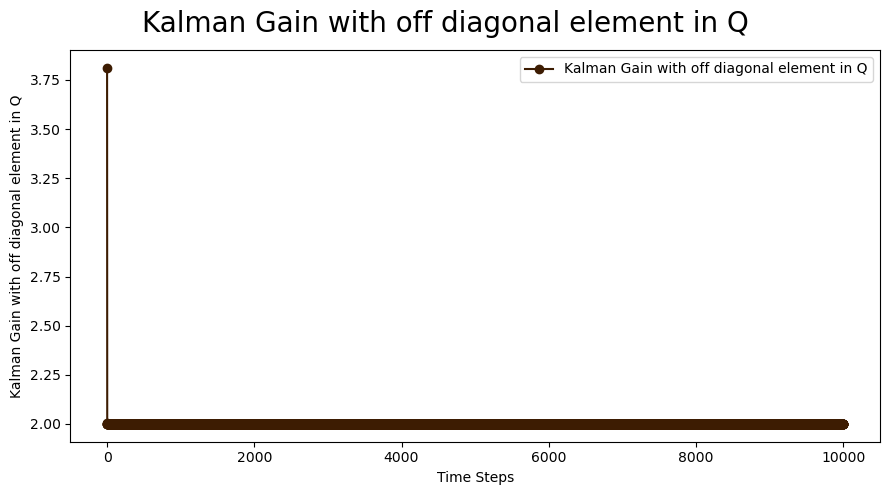

In [33]:
# Initialize the plot for Kalman gain
plotSingularData(1, time_steps, Kalman_gain_list_loop_Q, 'o', 'Kalman Gain with off diagonal element in Q','#3D1C02')
# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

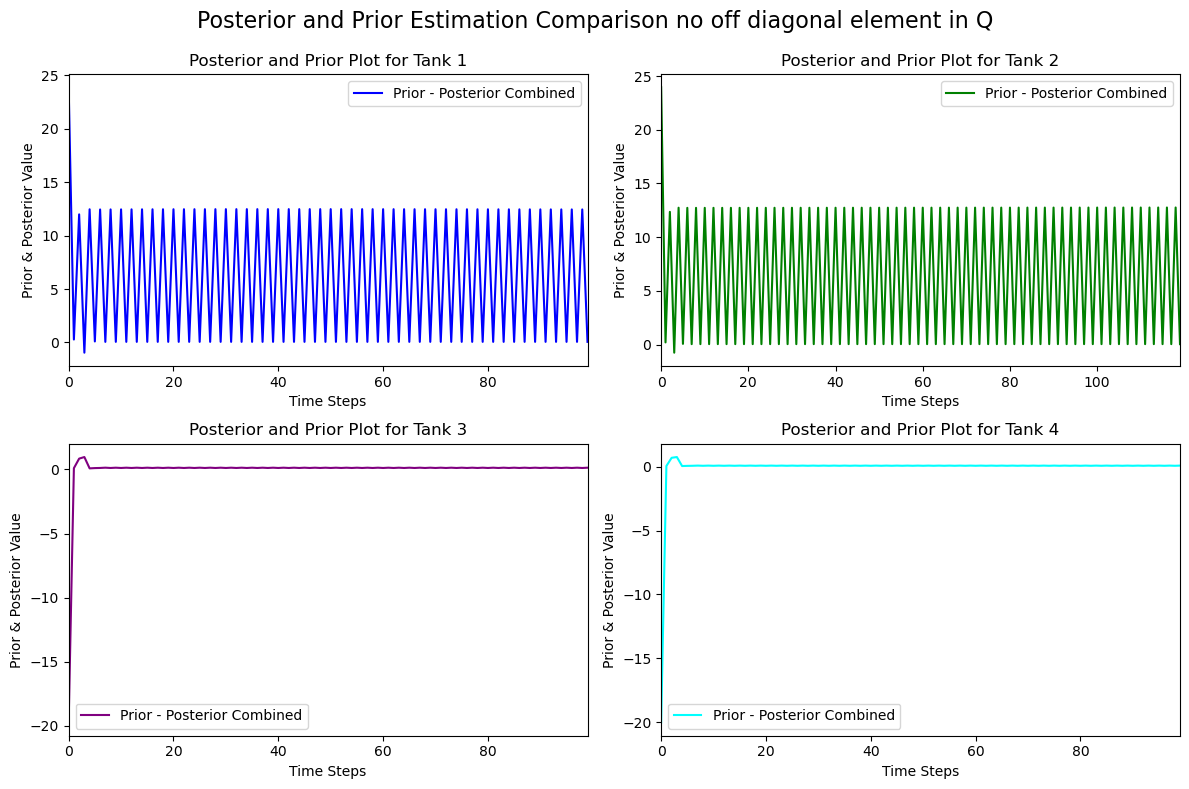

In [135]:
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior and Prior Estimation Comparison no off diagonal element in Q', fontsize=16)

plot_data(1, X_post_list_loop[:, 0][:50], X_prior_list_loop[:, 0][:50], 'Tank 1', posterior_color='blue', prior_color='orange')
plot_data(2, X_post_list_loop[:, 1][:60], X_prior_list_loop[:, 1][:60], 'Tank 2', posterior_color='green', prior_color='red')
plot_data(3, X_post_list_loop[:, 2][:50], X_prior_list_loop[:, 2][:50], 'Tank 3', posterior_color='purple', prior_color='yellow')
plot_data(4, X_post_list_loop[:, 3][:50], X_prior_list_loop[:, 3][:50], 'Tank 4', posterior_color='cyan', prior_color='magenta')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

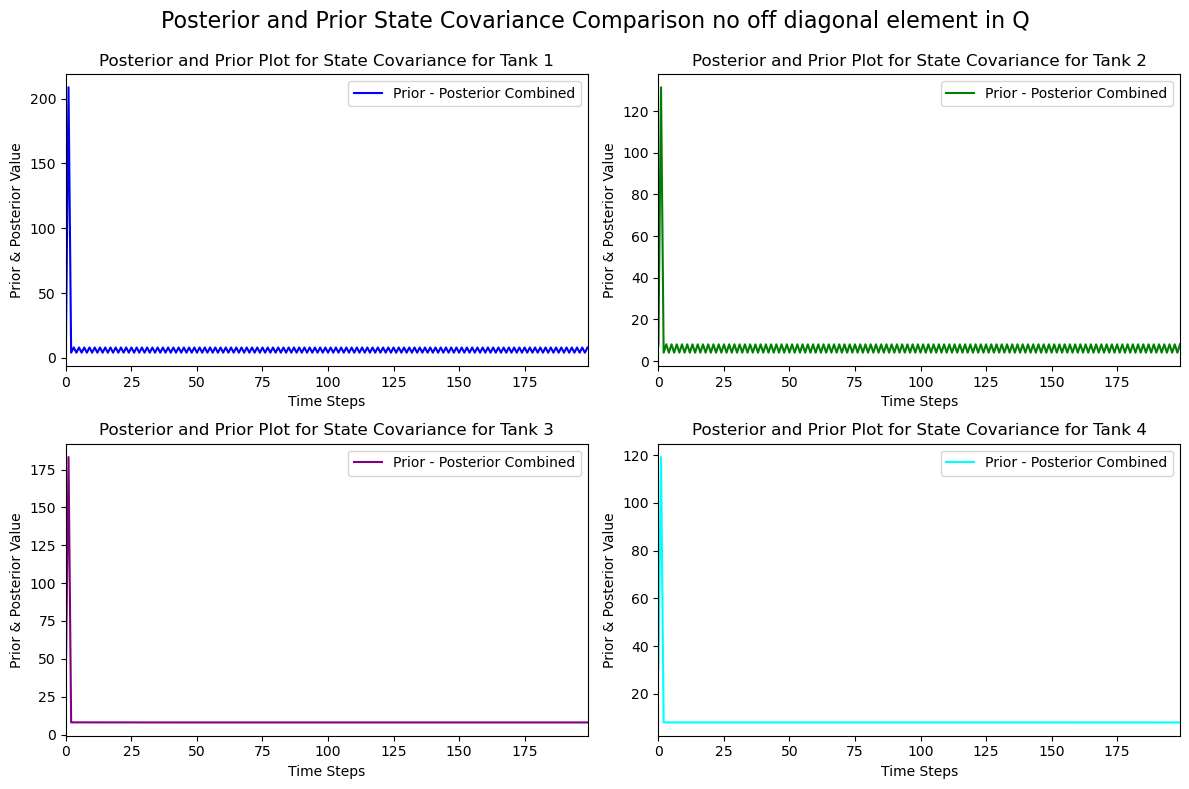

In [136]:
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior and Prior State Covariance Comparison no off diagonal element in Q', fontsize=16)

plot_data(1, P_post_list_loop[:, 0][:100], P_pri_list_loop[:, 0][:100], 'State Covariance for Tank 1', posterior_color='blue', prior_color='orange')
plot_data(2, P_post_list_loop[:, 1][:100], P_pri_list_loop[:, 1][:100], 'State Covariance for Tank 2', posterior_color='green', prior_color='red')
plot_data(3, P_post_list_loop[:, 2][:100], P_pri_list_loop[:, 2][:100], 'State Covariance for Tank 3', posterior_color='purple', prior_color='yellow')
plot_data(4, P_post_list_loop[:, 3][:100], P_pri_list_loop[:, 3][:100], 'State Covariance for Tank 4', posterior_color='cyan', prior_color='magenta')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

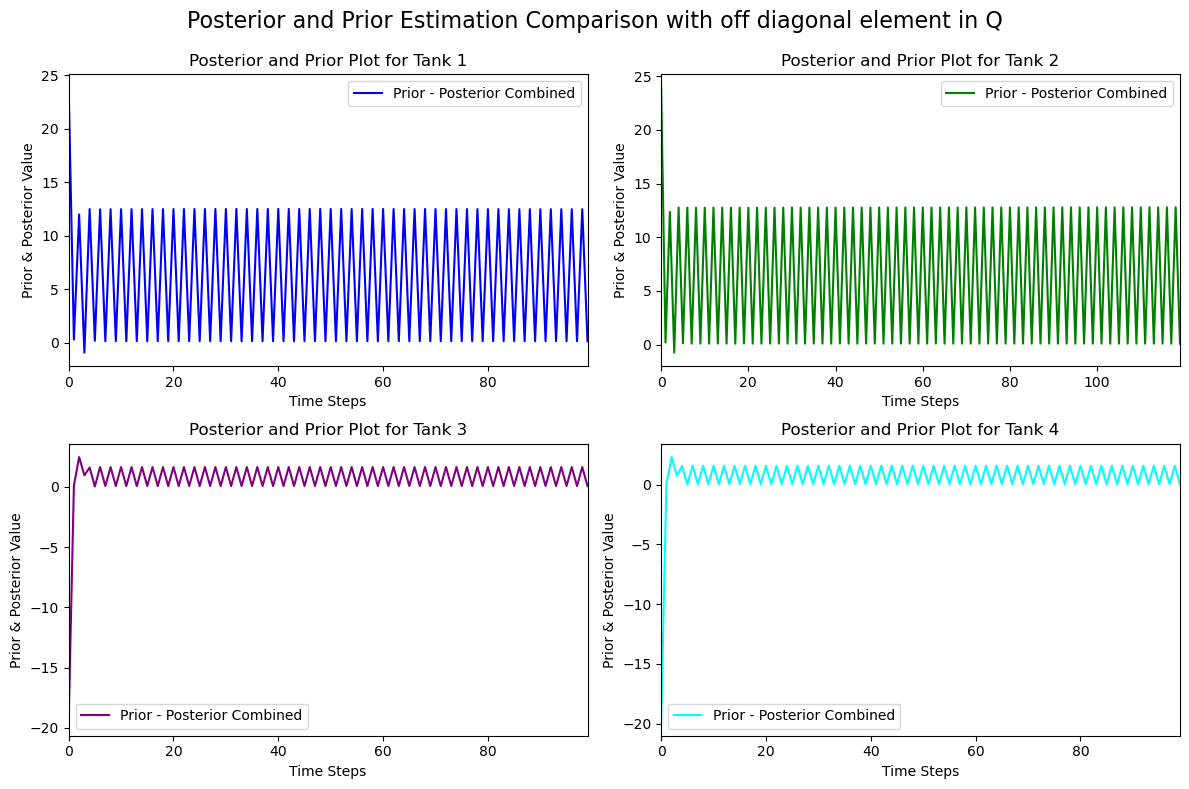

In [137]:
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior and Prior Estimation Comparison with off diagonal element in Q', fontsize=16)

plot_data(1, X_post_list_loop_Q[:, 0][:50], X_prior_list_loop_Q[:, 0][:50], 'Tank 1', posterior_color='blue', prior_color='orange')
plot_data(2, X_post_list_loop_Q[:, 1][:60], X_prior_list_loop_Q[:, 1][:60], 'Tank 2', posterior_color='green', prior_color='red')
plot_data(3, X_post_list_loop_Q[:, 2][:50], X_prior_list_loop_Q[:, 2][:50], 'Tank 3', posterior_color='purple', prior_color='yellow')
plot_data(4, X_post_list_loop_Q[:, 3][:50], X_prior_list_loop_Q[:, 3][:50], 'Tank 4', posterior_color='cyan', prior_color='magenta')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

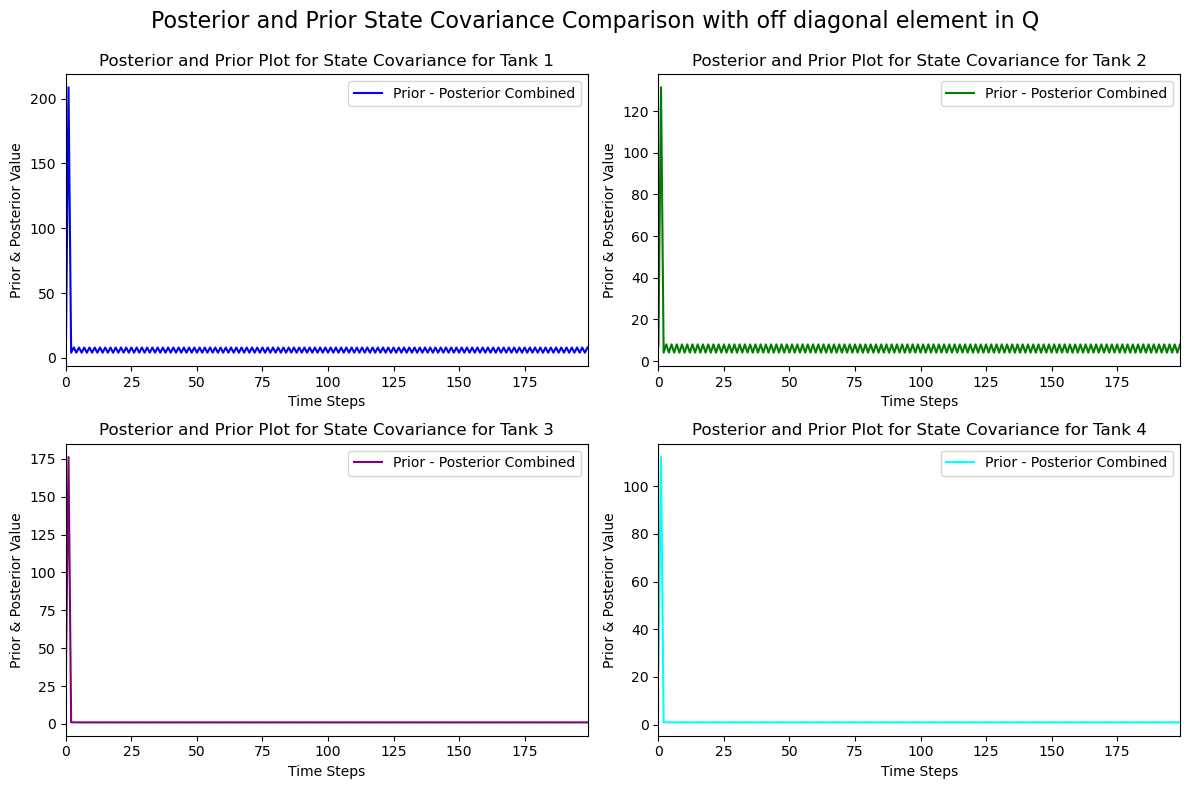

In [138]:
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior and Prior State Covariance Comparison with off diagonal element in Q', fontsize=16)

plot_data(1, P_post_list_loop_Q[:, 0][:100], P_pri_list_loop_Q[:, 0][:100], 'State Covariance for Tank 1', posterior_color='blue', prior_color='orange')
plot_data(2, P_post_list_loop_Q[:, 1][:100], P_pri_list_loop_Q[:, 1][:100], 'State Covariance for Tank 2', posterior_color='green', prior_color='red')
plot_data(3, P_post_list_loop_Q[:, 2][:100], P_pri_list_loop_Q[:, 2][:100], 'State Covariance for Tank 3', posterior_color='purple', prior_color='yellow')
plot_data(4, P_post_list_loop_Q[:, 3][:100], P_pri_list_loop_Q[:, 3][:100], 'State Covariance for Tank 4', posterior_color='cyan', prior_color='magenta')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Kalman Filter Result - 1st Approach with no off diagonal element in Q

In [38]:
# Create a dataframe with the results
results_dataframe = pd.DataFrame({
    'Time_Step': time_steps,
    'Original_Tank1_Reading': tank1_measurements,
    'KalmanFilter_Tank1_Estimate': X_post_list_loop[:, 0],
    'Original_Tank2_Reading': tank2_measurements,
    'KalmanFilter_Tank2_Estimate': X_post_list_loop[:, 1],
    'Original_Tank3_Reading': tank3_measurements,
    'KalmanFilter_Tank3_Estimate': X_post_list_loop[:, 2],
    'Original_Tank4_Reading': tank4_measurements,
    'KalmanFilter_Tank4_Estimate': X_post_list_loop[:, 3],
})

# Display the dataframe
display(results_dataframe)

,Time_Step,Original_Tank1_Reading,KalmanFilter_Tank1_Estimate,Original_Tank2_Reading,KalmanFilter_Tank2_Estimate,Original_Tank3_Reading,KalmanFilter_Tank3_Estimate,Original_Tank4_Reading,KalmanFilter_Tank4_Estimate
0,0,12.400000,23.894577,12.700000,23.954857,1.800000,-19.732607,1.400000,-20.024606
1,1,12.404928,11.992987,12.700618,12.360638,1.792881,0.846152,1.400301,0.702195
2,2,12.409478,12.468171,12.701239,12.746208,1.786060,0.086269,1.400592,0.056100
3,3,12.413670,12.452577,12.701863,12.733903,1.779526,0.118228,1.400873,0.077680
4,4,12.417521,12.457223,12.702490,12.734957,1.773266,0.116885,1.401145,0.076961
...,...,...,...,...,...,...,...,...,...
9996,9996,12.262968,12.303689,12.783158,12.815211,1.633941,0.117201,1.409045,0.076896
9997,9997,12.262968,12.303689,12.783158,12.815211,1.633941,0.117201,1.409045,0.076896
9998,9998,12.262968,12.303689,12.783158,12.815211,1.633941,0.117201,1.409045,0.076896
9999,9999,12.262968,12.303689,12.783158,12.815211,1.633941,0.117201,1.409045,0.076896


##### Kalman Filter Result - 1st Approach with off diagonal element in Q

In [39]:
# Create a dataframe with the results
results_dataframe_Q = pd.DataFrame({
    'Time_Step': time_steps,
    'Original_Tank1_Reading': tank1_measurements,
    'KalmanFilter_Tank1_Estimate': np.array(X_post_list_loop_Q)[:, 0],
    'Original_Tank2_Reading': tank2_measurements,
    'KalmanFilter_Tank2_Estimate': np.array(X_post_list_loop_Q)[:, 1],
    'Original_Tank3_Reading': tank3_measurements,
    'KalmanFilter_Tank3_Estimate': np.array(X_post_list_loop_Q)[:, 2],
    'Original_Tank4_Reading': tank4_measurements,
    'KalmanFilter_Tank4_Estimate': np.array(X_post_list_loop_Q)[:, 3],
})

# Display the dataframe
display(results_dataframe_Q)

,Time_Step,Original_Tank1_Reading,KalmanFilter_Tank1_Estimate,Original_Tank2_Reading,KalmanFilter_Tank2_Estimate,Original_Tank3_Reading,KalmanFilter_Tank3_Estimate,Original_Tank4_Reading,KalmanFilter_Tank4_Estimate
0,0,12.400000,23.894577,12.700000,23.954857,1.800000,-19.551964,1.400000,-19.911428
1,1,12.404928,11.988740,12.700618,12.357942,1.792881,2.485029,1.400301,2.310184
2,2,12.409478,12.492546,12.701239,12.766437,1.786060,1.616665,1.400592,1.556114
3,3,12.413670,12.474422,12.701863,12.752186,1.779526,1.655159,1.400873,1.584643
4,4,12.417521,12.479223,12.702490,12.753367,1.773266,1.653557,1.401145,1.584054
...,...,...,...,...,...,...,...,...,...
9996,9996,12.262968,12.325998,12.783158,12.833276,1.633941,1.663424,1.409045,1.565202
9997,9997,12.262968,12.325998,12.783158,12.833276,1.633941,1.663424,1.409045,1.565202
9998,9998,12.262968,12.325998,12.783158,12.833276,1.633941,1.663424,1.409045,1.565202
9999,9999,12.262968,12.325998,12.783158,12.833276,1.633941,1.663424,1.409045,1.565202


In [40]:
results_dataframe.to_csv('Comparison_Kalman_Approach1.csv', sep=',', index=False, encoding='utf-8')
results_dataframe_Q.to_csv('Comparison_Kalman_Approach1_Q.csv', sep=',', index=False, encoding='utf-8')

### **Conclusion of 1st Approach:**

##### 1. Noteworthy Convergence: The implemented Kalman filter exhibits impressive convergence towards the actual reading values for all four tanks. Despite deliberately choosing diverse initial values, the Kalman filter demonstrates its efficacy by effectively converging these values.

##### 2. Robustness and Effectiveness: The convergence of the estimated values highlights the robustness and effectiveness of the Kalman filter in accurately estimating the true values of the tanks. This is achieved even when considering the modified process noise covariance, taking into account the internal relation of different tanks.

##### 3. Influence of Off-Diagonal Elements in Q Matrix: The presence of off-diagonal elements in the Q matrix plays a crucial role in achieving convergence for Tank 3 and Tank 4 estimates with their respective measurement values. By incorporating the appropriate off-diagonal terms, the Kalman filter effectively captures the interdependencies and improves the accuracy of estimation.

<h3 style='text-align: center;'>=======================End of Kalman Filter Implementation - Approach 1=======================</h3>

### Why second approach has considered : 

1. Approach 1 of the Kalman filter estimation encountered a challenge in aligning all the measurements. The measurements obtained from the system might not be synchronized or aligned perfectly, which can lead to inconsistencies in the estimation process. To overcome this challenge and improve the accuracy of the estimation, we propose an alternative approach that involves a more in-depth analysis of the different measurement units and addresses the specific requirements of the 4 tank problem described in the paper "Kalman Filter Based on The Quadruple-Tank Process: A Multivariable Laboratory Process with an Adjustable Zero" by Karl Henrik Johansson.

2. In this proposed approach, we carefully consider the characteristics and units of the measurements involved. The paper discusses a multivariable laboratory process with an adjustable zero, where the system consists of four tanks. Each tank has its own set of measurements and variables that influence its behavior. By analyzing the units and relationships between the variables, we can tailor the Kalman filter estimation specifically to this problem statement.

3. The first step in the proposed approach is to thoroughly analyze the different measurements and their units. This analysis helps us understand the physical meaning and relationships between the measurements, such as the fluid levels in each tank, the flow rates, and the control inputs. By understanding these relationships, we can derive specific equations that capture the dynamics of the system and express them in terms of the measurements and variables involved.

4. Once we have derived the appropriate equations, we can construct a state transition matrix (A) that describes the dynamics of the system. This matrix captures the relationships between the state variables of the system at each time step. Additionally, we define a control input matrix (B) that represents the effect of the control inputs on the system dynamics.

5. To account for measurement noise and uncertainties, we define the measurement noise covariance matrix (R) and the process noise covariance matrix (Q). These matrices capture the uncertainties associated with the measurements and the system dynamics, respectively. They are essential for accurately estimating the state of the system and updating the state covariance matrix.

6. The observation matrix (H) is defined based on the specific measurements available in the problem statement. This matrix relates the state variables to the measurements, allowing us to compare the predicted measurements with the actual measurements and calculate the measurement residual.

7. Using the derived equations, matrices, and measurements, we can perform the Kalman filter estimation. The estimation process involves predicting the measurements based on the current state estimate, comparing them with the actual measurements, and adjusting the state estimate and covariance based on the measurement residual. This iterative process continues for each time step, refining the estimation and reducing the estimation errors.

8. One advantage of this approach is that it takes into account the specific characteristics of the 4 tank problem, leading to a more tailored and accurate estimation. By carefully analyzing the units, relationships, and dynamics of the measurements, we can design a Kalman filter that aligns with the problem requirements and provides more reliable estimates.

9. However, it's important to note that this approach might not be as generic as the first approach. It relies on the specific understanding of the 4 tank problem and may not be directly applicable to other systems or scenarios. Therefore, it is crucial to consider the problem statement and adapt the approach accordingly for different applications.

<h2 style='text-align: center;'>Kalman Filter - 2nd Approach</h2>

#### Unit measurement for different caluclated values are shown below which is used in this second approach Kalman filter implementation.

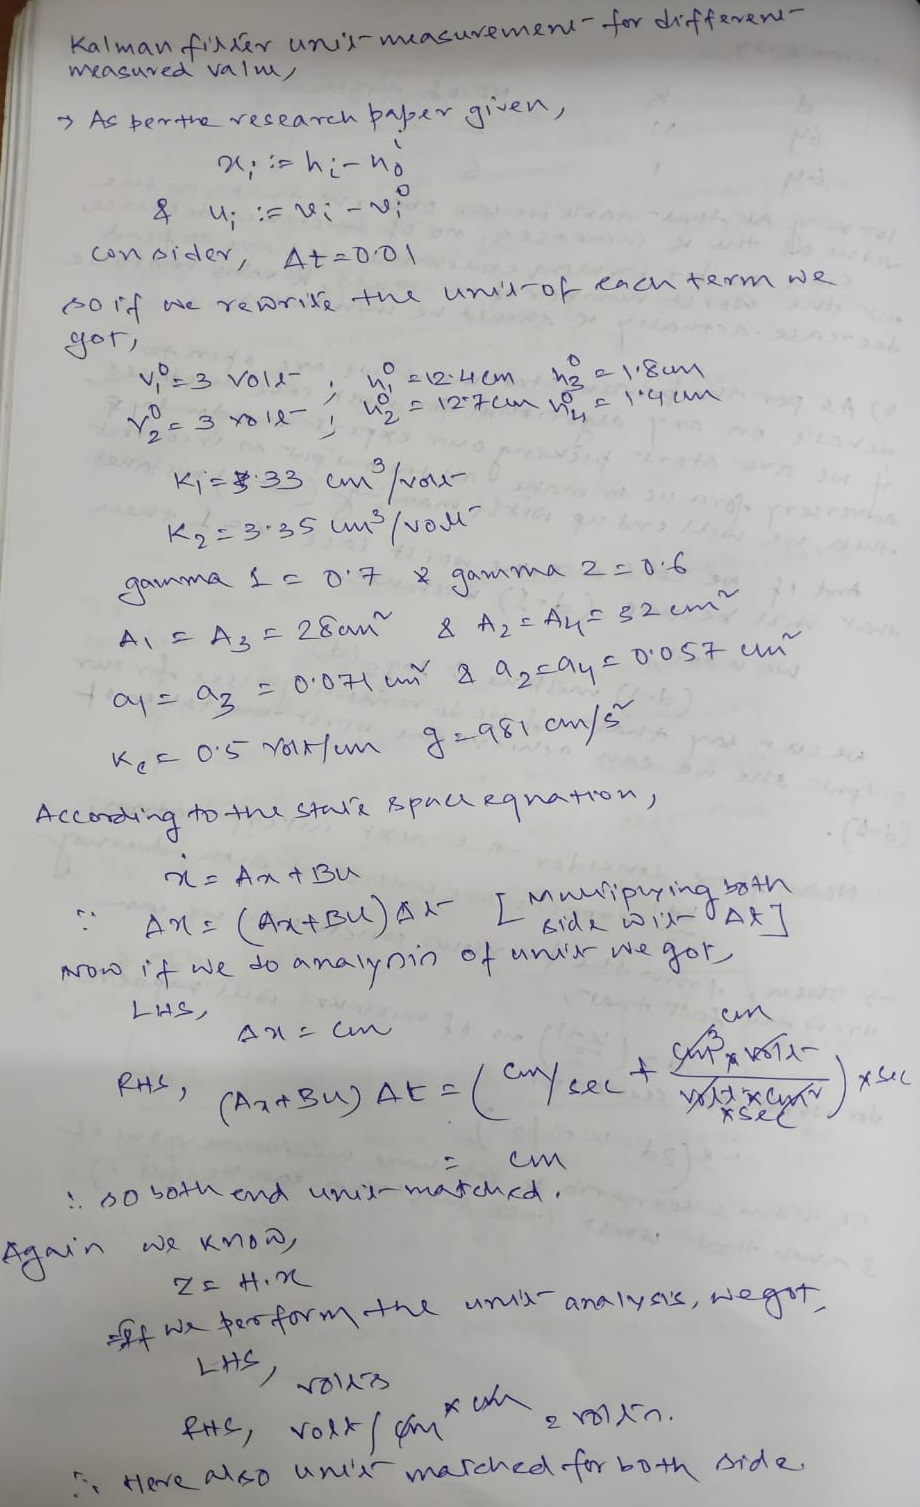

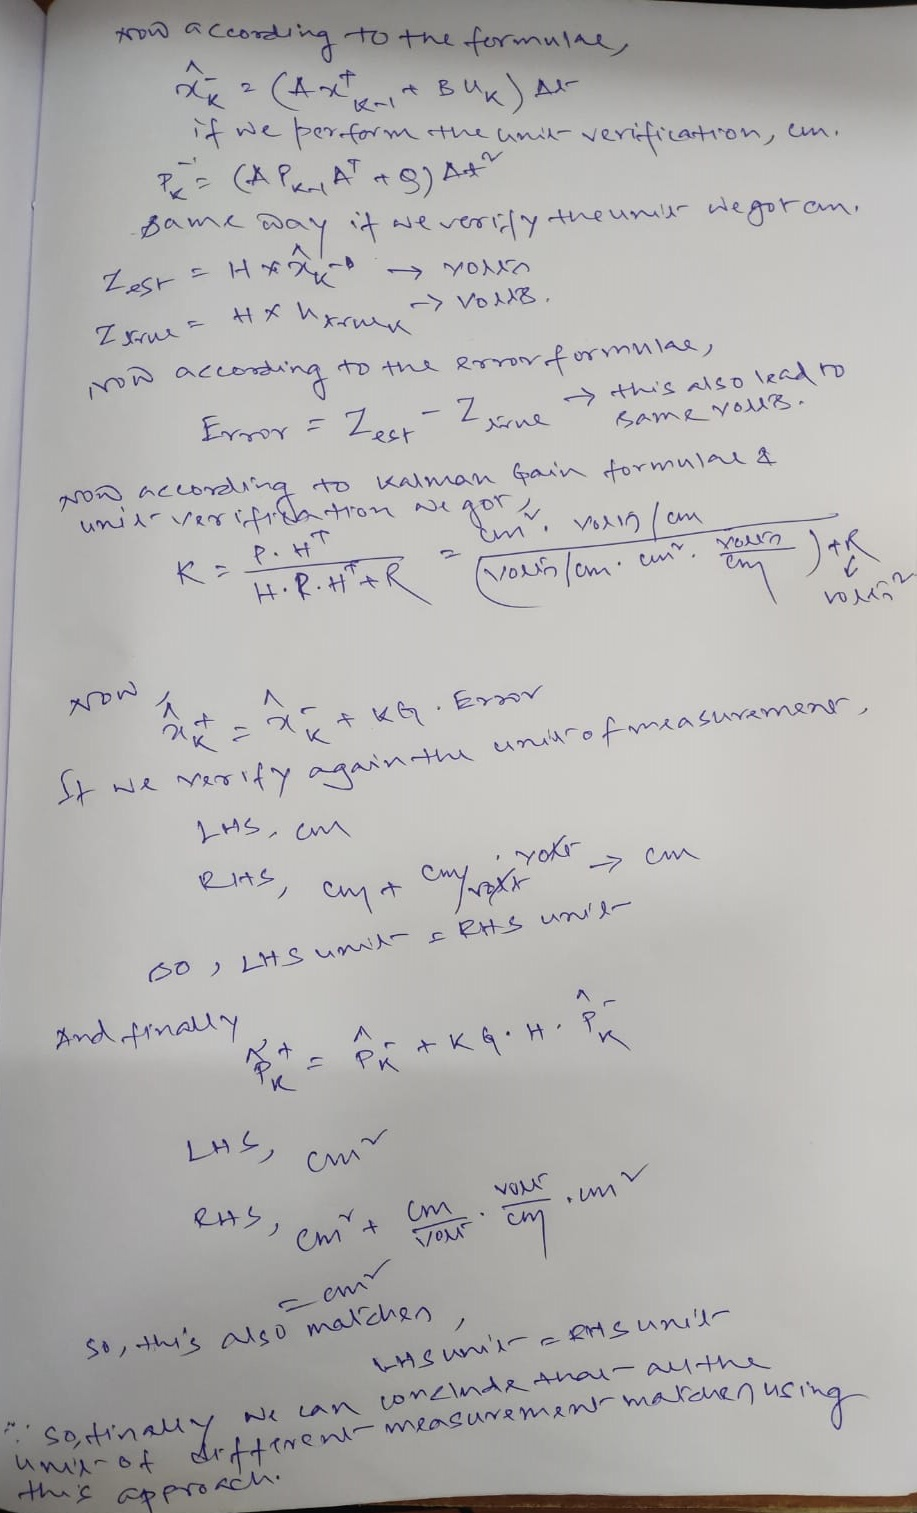

#### Looping through different combination of constant value to multiply with process noise covariance to see the best convergence for estimation

In [41]:
for hyperparameter_process_noise in range(0,2000,100):
    for hyperparameter_measurement_noise in np.arange(0.001, 1.0, 0.1):
        measurement_noise_cov_tuning =  hyperparameter_measurement_noise * np.eye(2) # Measurement noise covariance
        process_noise_cov_tuning = hyperparameter_process_noise * np.eye(num_tanks)  # Process noise covariance 
        print(f'hyperparameter measurement noise: {hyperparameter_measurement_noise} & hyperparameter_process_noise: {hyperparameter_process_noise}')
        X_posterior_store, X_prior_store, P_posterior_store, P_prior_store, Kalman_Gain_store, Innovation_store, Residue_store = kalman_filter_simulation_2ndVersion(np.array(tank_measurement_data),tank_measurement_data.to_numpy()[0,:],state_transition_matrix,control_input_matrix,observation_matrix,control_input,process_noise_cov_tuning,measurement_noise_cov_tuning,delta_t)

hyperparameter measurement noise: 0.001 & hyperparameter_process_noise: 0
Estimation Tank 1: 12.28906316472943
Estimation Tank 2: 12.804470654693956
Estimation Tank 3: 1.6501045965730945
Estimation Tank 4: 1.418788313780197
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 0
Estimation Tank 1: 12.28906316472943
Estimation Tank 2: 12.804470654693956
Estimation Tank 3: 1.6501045965730945
Estimation Tank 4: 1.418788313780197
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 0
Estimation Tank 1: 12.28906316472943
Estimation Tank 2: 12.804470654693956
Estimation Tank 3: 1.6501045965730945
Estimation Tank 4: 1.418788313780197
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 0
Estimation Tank 1: 12.28906316472943
Estimation Tank 2: 12.804470654693956
Estimation Tank 3: 1.6501045965730945
Estimation Tank 4: 1.418788313780197
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 0
Estimation Tank 

Estimation Tank 1: 12.274586466893734
Estimation Tank 2: 12.792645041727837
Estimation Tank 3: 1.650104849621653
Estimation Tank 4: 1.4187884449724626
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 300
Estimation Tank 1: 12.275584983448969
Estimation Tank 2: 12.793460500155224
Estimation Tank 3: 1.650104832167905
Estimation Tank 4: 1.4187884359258534
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 300
Estimation Tank 1: 12.276454644160467
Estimation Tank 2: 12.794170750310847
Estimation Tank 3: 1.6501048169665111
Estimation Tank 4: 1.418788428046412
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 300
Estimation Tank 1: 12.277218879937639
Estimation Tank 2: 12.794794918897747
Estimation Tank 3: 1.6501048036079085
Estimation Tank 4: 1.4187884211219495
hyperparameter measurement noise: 0.001 & hyperparameter_process_noise: 400
Estimation Tank 1: 12.262993630209762
Estimation Tank 2: 12.78317971728128
Est

Estimation Tank 1: 12.26565980253009
Estimation Tank 2: 12.785356236404969
Estimation Tank 3: 1.6501050056566278
Estimation Tank 4: 1.4187885258336217
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 700
Estimation Tank 1: 12.266802408222397
Estimation Tank 2: 12.78628906358344
Estimation Tank 3: 1.6501049856843042
Estimation Tank 4: 1.418788515484953
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 700
Estimation Tank 1: 12.267838637994299
Estimation Tank 2: 12.787135079109753
Estimation Tank 3: 1.6501049675713857
Estimation Tank 4: 1.4187885060993601
hyperparameter measurement noise: 0.501 & hyperparameter_process_noise: 700
Estimation Tank 1: 12.268782686419124
Estimation Tank 2: 12.787905862599354
Estimation Tank 3: 1.6501049510697583
Estimation Tank 4: 1.4187884975483807
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 700
Estimation Tank 1: 12.269646330156085
Estimation Tank 2: 12.7886

Estimation Tank 1: 12.269307284766802
Estimation Tank 2: 12.788334190941335
Estimation Tank 3: 1.6501049418999656
Estimation Tank 4: 1.4187884927965568
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 1000
Estimation Tank 1: 12.269888841960293
Estimation Tank 2: 12.788809035191047
Estimation Tank 3: 1.6501049317345509
Estimation Tank 4: 1.4187884875286905
hyperparameter measurement noise: 0.001 & hyperparameter_process_noise: 1100
Estimation Tank 1: 12.262977020385357
Estimation Tank 2: 12.783166158589244
Estimation Tank 3: 1.6501050525506367
Estimation Tank 4: 1.4187885501300639
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 1100
Estimation Tank 1: 12.263893394735742
Estimation Tank 2: 12.783914212499678
Estimation Tank 3: 1.650105036532767
Estimation Tank 4: 1.4187885418312511
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 1100
Estimation Tank 1: 12.264747571643598
Estimation Tank 2: 12.784611516247656
Estimatio

Estimation Tank 1: 12.265653794719416
Estimation Tank 2: 12.785351331711846
Estimation Tank 3: 1.650105005761642
Estimation Tank 4: 1.418788525888034
hyperparameter measurement noise: 0.501 & hyperparameter_process_noise: 1400
Estimation Tank 1: 12.266239689639743
Estimation Tank 2: 12.785829653299839
Estimation Tank 3: 1.650104995520417
Estimation Tank 4: 1.418788520581594
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 1400
Estimation Tank 1: 12.26679697279072
Estimation Tank 2: 12.786284625985388
Estimation Tank 3: 1.6501049857793133
Estimation Tank 4: 1.4187885155341833
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 1400
Estimation Tank 1: 12.267327690074598
Estimation Tank 2: 12.786717918674968
Estimation Tank 3: 1.6501049765025697
Estimation Tank 4: 1.4187885107272873
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 1400
Estimation Tank 1: 12.267833696876322
Estimation Tank 2: 12.787

Estimation Tank 1: 12.262973326438537
Estimation Tank 2: 12.783163143201042
Estimation Tank 3: 1.6501050526152055
Estimation Tank 4: 1.4187885501635162
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 1800
Estimation Tank 1: 12.263541248380166
Estimation Tank 2: 12.783626745698173
Estimation Tank 3: 1.6501050426881496
Estimation Tank 4: 1.4187885450203708
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 1800
Estimation Tank 1: 12.264084972033592
Estimation Tank 2: 12.784070603912436
Estimation Tank 3: 1.6501050331840692
Estimation Tank 4: 1.418788540096265
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 1800
Estimation Tank 1: 12.264606011719081
Estimation Tank 2: 12.784495952874476
Estimation Tank 3: 1.650105024076494
Estimation Tank 4: 1.4187885353774983
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 1800
Estimation Tank 1: 12.265105757984347
Estimation Tank 2: 12.784903926714

##### Explanation on choosing the process noise covariance value: 
- I have been tuning the hyperparameters to improve the accuracy of the estimation. Among the various hyperparameter values tested, any higher value of process noise covariance with a combination of lower value of measurement noise covariance converging the result well.
- Based on this observation, I have utilized 1000 as hyperparameter value for process noice covariance and 0.001 as measurement noise covariance as a multiplier term with identity matrix. This modification aims to adjust the uncertainty in the system dynamics, considering the estimates of all four tanks.

In [42]:
process_noise_cov_final = 1000 * np.eye(num_tanks)
measurement_noise_cov_final = 0.001 * np.eye(num_voltage_source)

#### Calling Kalman filter function for estimation with new process noise covariance matrix and measurement noice covaraince

In [43]:
X_posterior_store, X_prior_store, P_posterior_store, P_prior_store, Kalman_Gain_store, Innovation_store, Residue_store = kalman_filter_simulation_2ndVersion(np.array(tank_measurement_data),tank_measurement_data.to_numpy()[0,:],state_transition_matrix,control_input_matrix,observation_matrix,control_input,process_noise_cov_final,measurement_noise_cov_final,delta_t)

Estimation Tank 1: 12.26297797008833
Estimation Tank 2: 12.78316693383684
Estimation Tank 3: 1.6501050525340362
Estimation Tank 4: 1.4187885501214632


#### Looking at the estimated measurement we can see that is convereged with actual value. So now plotting different graphical result to visualize the details accurately

#### Prior Plots

In [44]:
# Initialize the plot for Prior : Original and Kalman Filter Results
X_prior_tank1 = [X_prior_store[i][0][0] for i in range(10000)]
X_prior_tank2 = [X_prior_store[i][1][0] for i in range(10000)]
X_prior_tank3 = [X_prior_store[i][2][0] for i in range(10000)]
X_prior_tank4 = [X_prior_store[i][3][0] for i in range(10000)]

In [45]:
print(f'Tank 1 : Prior Estimate : {np.mean(X_prior_tank1)}')
print(f'Tank 2 : Prior Estimate : {np.mean(X_prior_tank2)}')
print(f'Tank 3 : Prior Estimate : {np.mean(X_prior_tank3)}')
print(f'Tank 4 : Prior Estimate : {np.mean(X_prior_tank4)}')

Tank 1 : Prior Estimate : 12.29100719084758
Tank 2 : Prior Estimate : 12.803626694873964
Tank 3 : Prior Estimate : 1.6515453651671905
Tank 4 : Prior Estimate : 1.419864062654394


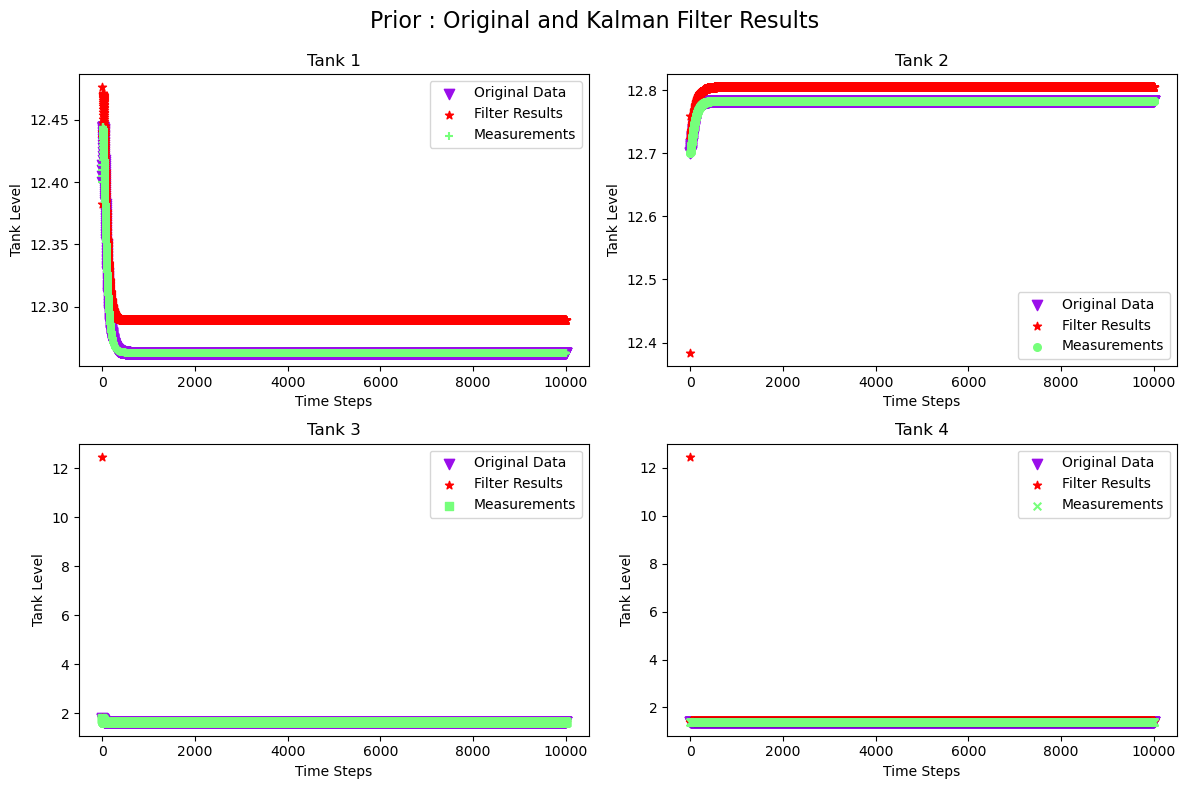

In [128]:
plt.figure(figsize=(12, 8))
plt.suptitle('Prior : Original and Kalman Filter Results', fontsize=16)

plot_filterwise_tank_data(1, time_steps_10000, tank1_measurements[0:10000], X_prior_tank1, tank1_measurements[0:10000], 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps_10000, tank2_measurements[0:10000], X_prior_tank2, tank2_measurements[0:10000], 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps_10000, tank3_measurements[0:10000], X_prior_tank3, tank3_measurements[0:10000], 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps_10000, tank4_measurements[0:10000], X_prior_tank4, tank4_measurements[0:10000], 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Posterior Plots

In [47]:
# Initialize the plot for Posterior : Original and Kalman Filter Results
X_posterior_tank1 = [X_posterior_store[i][0][0] for i in range(10000)]
X_posterior_tank2 = [X_posterior_store[i][1][0] for i in range(10000)]
X_posterior_tank3 = [X_posterior_store[i][2][0] for i in range(10000)]
X_posterior_tank4 = [X_posterior_store[i][3][0] for i in range(10000)]

In [48]:
print(f'Tank 1 : Posterior Estimate : {np.mean(X_posterior_tank1)}')
print(f'Tank 2 : Posterior Estimate : {np.mean(X_posterior_tank2)}')
print(f'Tank 3 : Posterior Estimate : {np.mean(X_posterior_tank3)}')
print(f'Tank 4 : Posterior Estimate : {np.mean(X_posterior_tank4)}')

Tank 1 : Posterior Estimate : 12.264872535758478
Tank 2 : Posterior Estimate : 12.782332003112531
Tank 3 : Posterior Estimate : 1.6515455642122692
Tank 4 : Posterior Estimate : 1.419861173806689


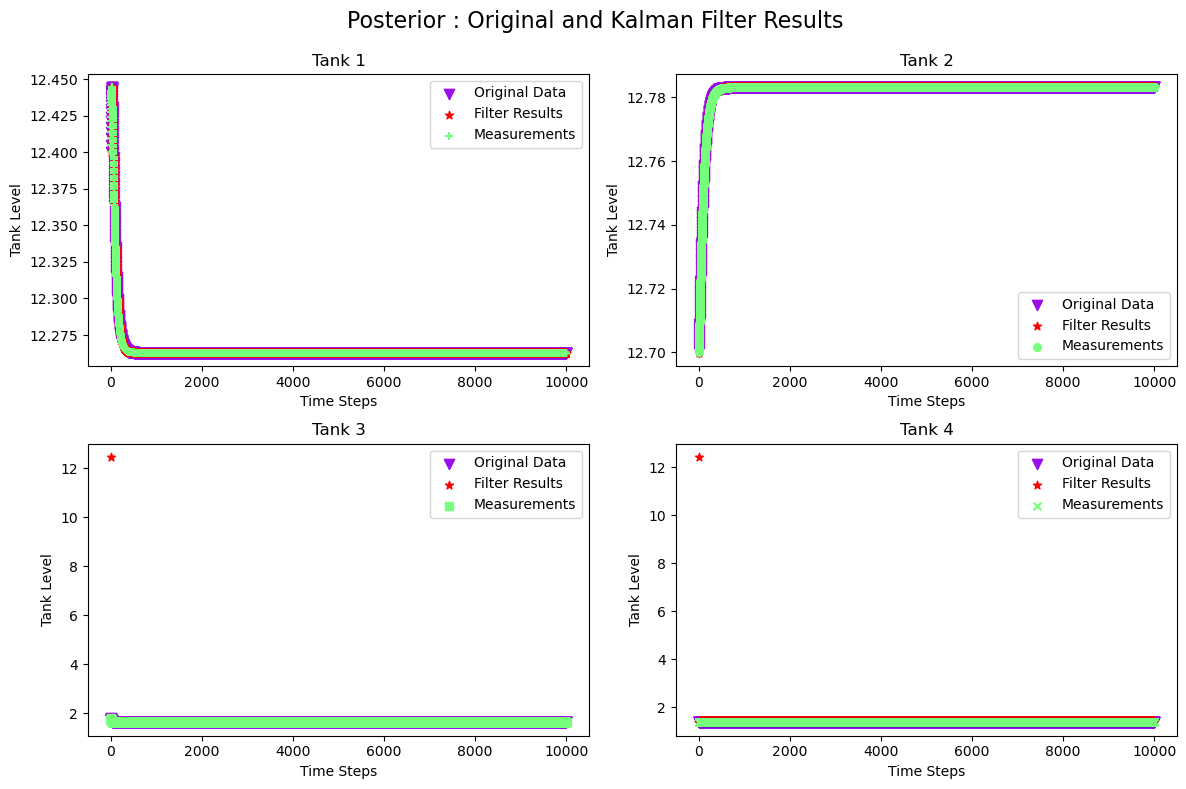

In [127]:
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior : Original and Kalman Filter Results', fontsize=16)

plot_filterwise_tank_data(1, time_steps_10000, tank1_measurements[0:10000], X_posterior_tank1, tank1_measurements[0:10000], 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps_10000, tank2_measurements[0:10000], X_posterior_tank2, tank2_measurements[0:10000], 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps_10000, tank3_measurements[0:10000], X_posterior_tank3, tank3_measurements[0:10000], 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps_10000, tank4_measurements[0:10000], X_posterior_tank4, tank4_measurements[0:10000], 'Tank 4', 'x')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Conclusion based on the posterior plot : 
###### Upon careful examination of the plot, it becomes apparent that the estimated values for all four tanks exhibit a notable convergence with their corresponding measured values. This observation reinforces the efficacy of the second approach employed in the Kalman filter implementation. These findings further validate the effectiveness of our methodology in accurately estimating the tank values, ultimately contributing to the advancement of state estimation techniques in the context of the four tank problem.

##### Different graphical plots for Kalman Filter using 2nd Approach

#### Residue plots

In [50]:
# Initialize the plot for Residual
resid_h1 = [Residue_store[i][0][0] for i in range(10000)]
resid_h2 = [Residue_store[i][1][0] for i in range(10000)]

In [51]:
print(f'Tank 1 : Residual Mean Value : {np.mean(resid_h1)}')
print(f'Tank 2 : Residual Mean Value : {np.mean(resid_h2)}')

Tank 1 : Residual Mean Value : 6.1324258140817935
Tank 2 : Residual Mean Value : 6.391157482386187


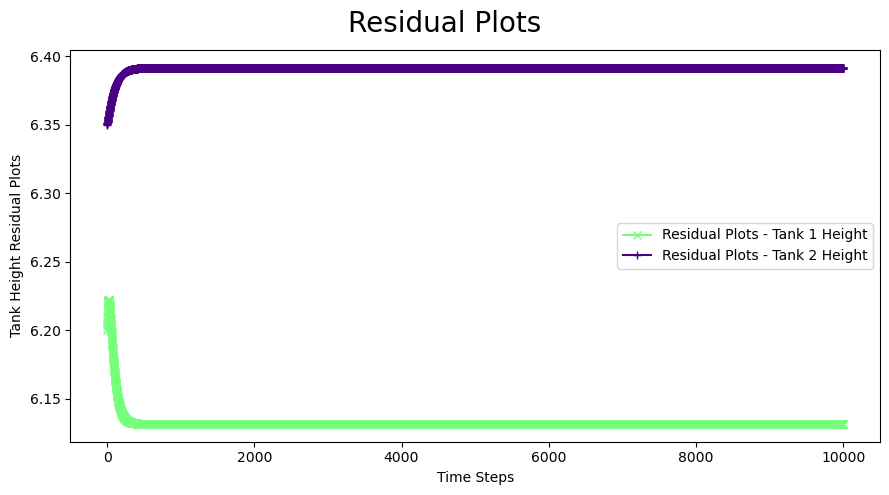

In [52]:
plotGraphicalData(1, time_steps_10000, [resid_h1, resid_h2], ['x', '+'], ['Tank Height Residual Plots', 'Tank Height Residual Plots'], ['#76FF7B', '#4B0082'], 'Residual Plots', ['Residual Plots - Tank 1 Height', 'Residual Plots - Tank 2 Height'])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Innovation plots

In [53]:
# Initialize the plot for innovation
innov_h1 = [Innovation_store[i][0][0] for i in range(10000)]
innov_h2 = [Innovation_store[i][1][0] for i in range(10000)]

In [54]:
print(f'Tank 1 : Innovation Mean Value : {np.mean(innov_h1)}')
print(f'Tank 2 : Innovation Mean Value : {np.mean(innov_h2)}')

Tank 1 : Innovation Mean Value : -0.013072554443273855
Tank 2 : Innovation Mean Value : -0.010651605465754893


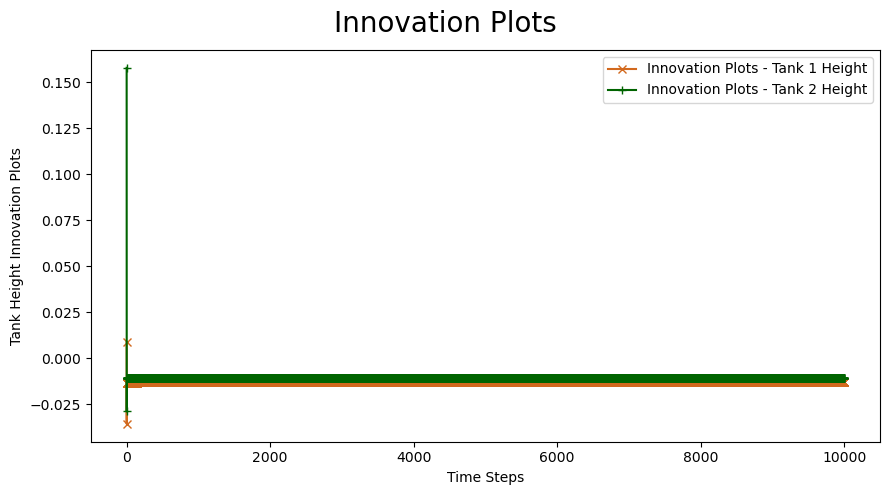

In [55]:
plotGraphicalData(1, time_steps_10000, [innov_h1, innov_h2], ['x', '+'], ['Tank Height Innovation Plots', 'Tank Height Innovation Plots'], ['#D2691E', '#006400'], 'Innovation Plots', ['Innovation Plots - Tank 1 Height', 'Innovation Plots - Tank 2 Height'])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Prior process state covariances trace plot

In [56]:
P_prior_plot = [P_prior_store[i] for i in range(10000)]

In [123]:
print(f'Prior process state covariances : {P_prior_plot}')

Prior process state covariances : [[12.00688429 11.23442485 11.7524905  11.11185784]
 [10.0002015  10.00012233 10.00020148 10.00012233]
 [10.00017526 10.00011119 10.00017525 10.00011119]
 ...
 [10.00017526 10.00011119 10.00017525 10.00011119]
 [10.00017526 10.00011119 10.00017525 10.00011119]
 [10.00017526 10.00011119 10.00017525 10.00011119]]


In [112]:
P_prior_plot = np.array(P_prior_plot)

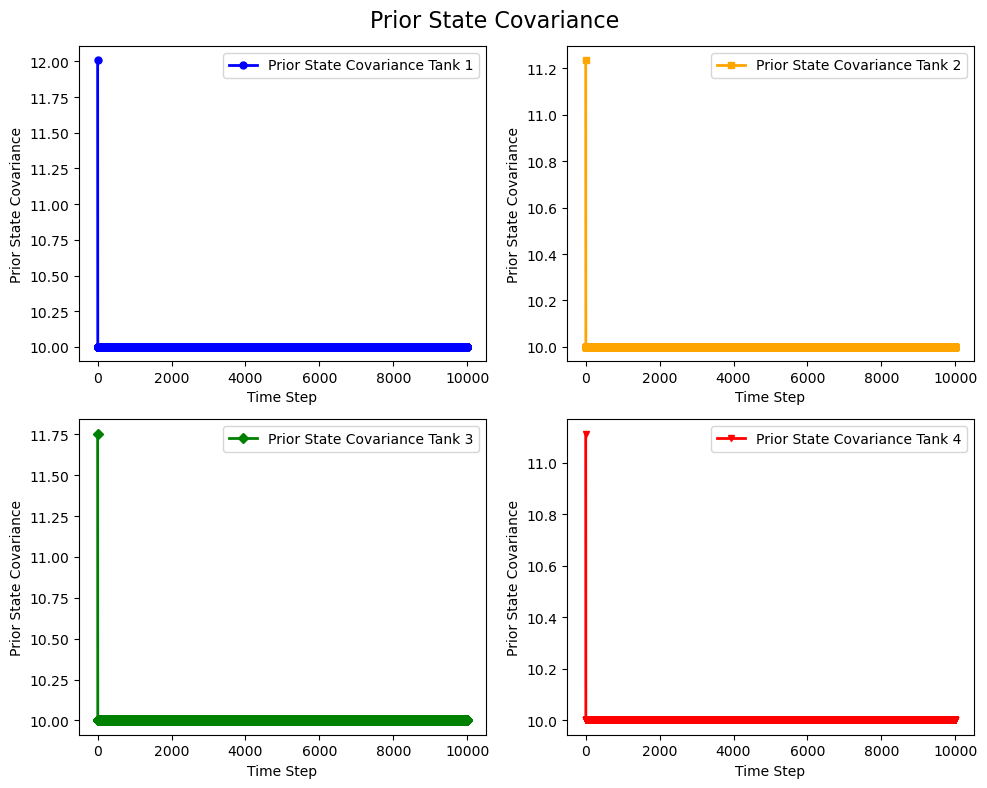

In [114]:
# Initialize the figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

plt.suptitle
# Define colors for the lines
colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 's', 'D', 'v']

# Iterate over each column of P_pri_list_loop and create a separate plot
for i, ax in enumerate(axs.flat):
    ax.plot(P_prior_plot[:, i], color=colors[i], marker=markers[i], markersize=5, linewidth=2)
    ax.set_ylabel(f'Prior State Covariance')
    ax.set_xlabel('Time Step')
    ax.legend([f'Prior State Covariance Tank {i+1}'], loc='upper right')

# Set the overall title for the figure
fig.suptitle('Prior State Covariance', fontsize=16)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

#### Posterior process state covariances plot

In [59]:
P_posterior_plot = [P_posterior_store[i] for i in range(10000)]

In [124]:
print(f'Posterior-measurement state covariances : {P_posterior_plot}')

Posterior-measurement state covariances : [[3.99866787e-03 3.99857631e-03 1.14967872e+01 1.10018577e+01]
 [3.99840067e-03 3.99840066e-03 1.00002015e+01 1.00001223e+01]
 [3.99840067e-03 3.99840066e-03 1.00001752e+01 1.00001112e+01]
 ...
 [3.99840067e-03 3.99840066e-03 1.00001752e+01 1.00001112e+01]
 [3.99840067e-03 3.99840066e-03 1.00001752e+01 1.00001112e+01]
 [3.99840067e-03 3.99840066e-03 1.00001752e+01 1.00001112e+01]]


In [115]:
P_posterior_plot = np.array(P_posterior_plot)

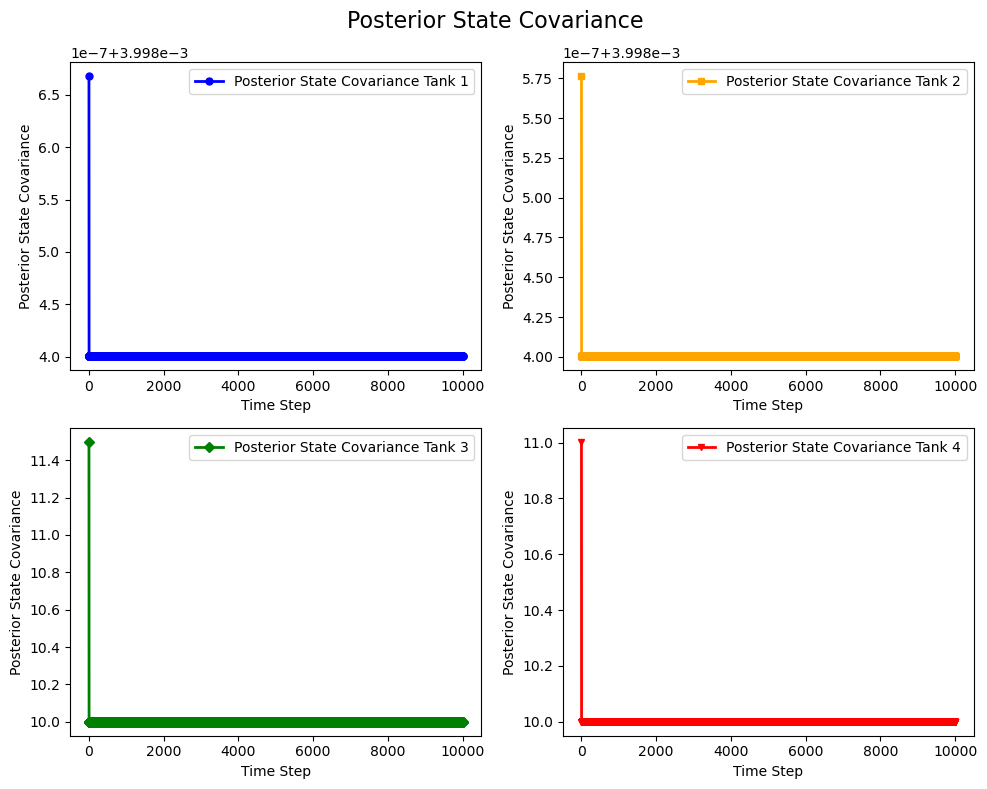

In [116]:
# Initialize the figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

plt.suptitle
# Define colors for the lines
colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 's', 'D', 'v']

# Iterate over each column of P_pri_list_loop and create a separate plot
for i, ax in enumerate(axs.flat):
    ax.plot(P_posterior_plot[:, i], color=colors[i], marker=markers[i], markersize=5, linewidth=2)
    ax.set_ylabel(f'Posterior State Covariance')
    ax.set_xlabel('Time Step')
    ax.legend([f'Posterior State Covariance Tank {i+1}'], loc='upper right')

# Set the overall title for the figure
fig.suptitle('Posterior State Covariance', fontsize=16)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

#### Prior & Posterior state covariances  plots

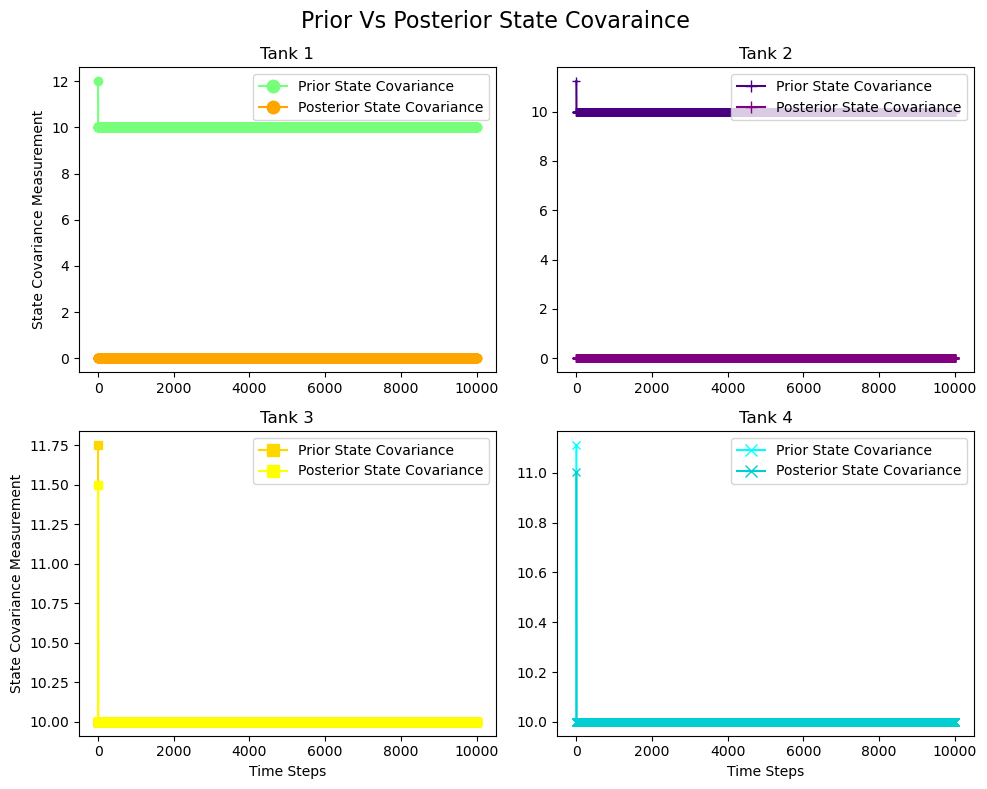

In [119]:
# Define colors and markers for the plots
prior_colors = ['#76FF7B', '#4B0082', '#FFD700', '#00FFFF']
posterior_colors = ['#FFA500', '#800080', '#FFFF00', '#00CED1']
markers = ['o', '+', 's', 'x']

# Create a 2x2 grid layout for the plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Prior Vs Posterior State Covaraince', fontsize=16)
# Iterate over the tanks and create plots in the grid layout
for i, ax in enumerate(axs.flat):
    # Plot Prior State Covariance
    ax.plot(time_steps_10000, P_prior_plot[:, i], label='Prior State Covariance', color=prior_colors[i], marker=markers[i])
    
    # Plot Posterior State Covariance
    ax.plot(time_steps_10000, P_posterior_plot[:, i], label='Posterior State Covariance', color=posterior_colors[i], marker=markers[i])
    
    # Set title for each subplot
    ax.set_title(f'Tank {i+1}')
    
    # Set x-axis label for the last row of subplots
    if i >= 2:
        ax.set_xlabel('Time Steps')
    
    # Set y-axis label for the first and third column of subplots
    if i % 2 == 0:
        ax.set_ylabel('State Covariance Measurement')
    
    # Show the legend for each subplot
    ax.legend(loc='upper right')

    # Add marker to the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', markerscale=1.5)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plots
plt.show()

#### Kalman Gain trace plots

In [63]:
Kalman_Gain_trace_plot = [Kalman_Gain_store[i] for i in range(10000)]

In [64]:
print(f'Kalman Gain : Trace Value : {Kalman_Gain_trace_plot}')

Kalman Gain : Trace Value : [3.9986220939392796, 3.9984006656294184, 3.99840066264182, 3.998400662641773, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.9984006626417736, 3.998400662641

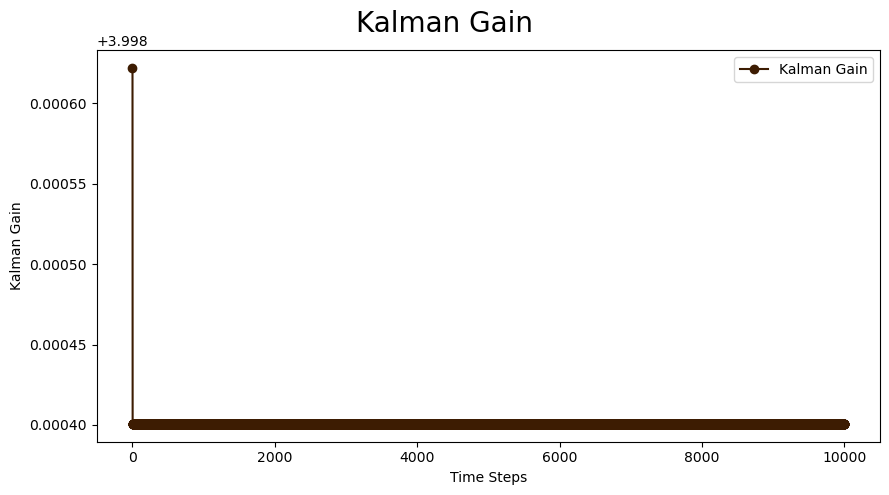

In [65]:
plotSingularData(1, time_steps_10000, np.array(Kalman_Gain_trace_plot), 'o', 'Kalman Gain', '#3D1C02')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Posterior and Prior plot

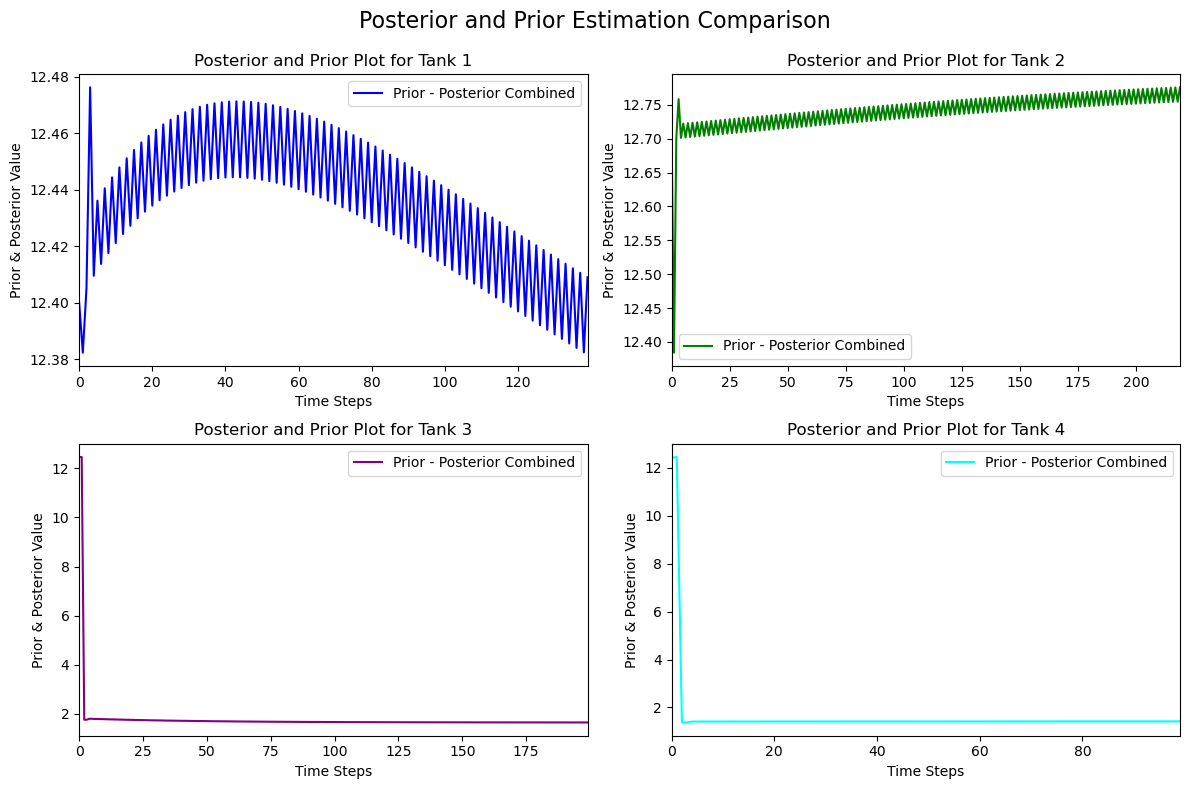

In [125]:
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior and Prior Estimation Comparison', fontsize=16)

plot_data(1, X_posterior_tank1[:70], X_prior_tank1[:70], 'Tank 1', posterior_color='blue', prior_color='orange')
plot_data(2, X_posterior_tank2[:110], X_prior_tank2[:110], 'Tank 2', posterior_color='green', prior_color='red')
plot_data(3, X_posterior_tank3[:100], X_prior_tank3[:100], 'Tank 3', posterior_color='purple', prior_color='yellow')
plot_data(4, X_posterior_tank4[:50], X_prior_tank4[:50], 'Tank 4', posterior_color='cyan', prior_color='magenta')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [67]:
P_posterior_store = np.array(P_posterior_store)
P_prior_store = np.array(P_prior_store)

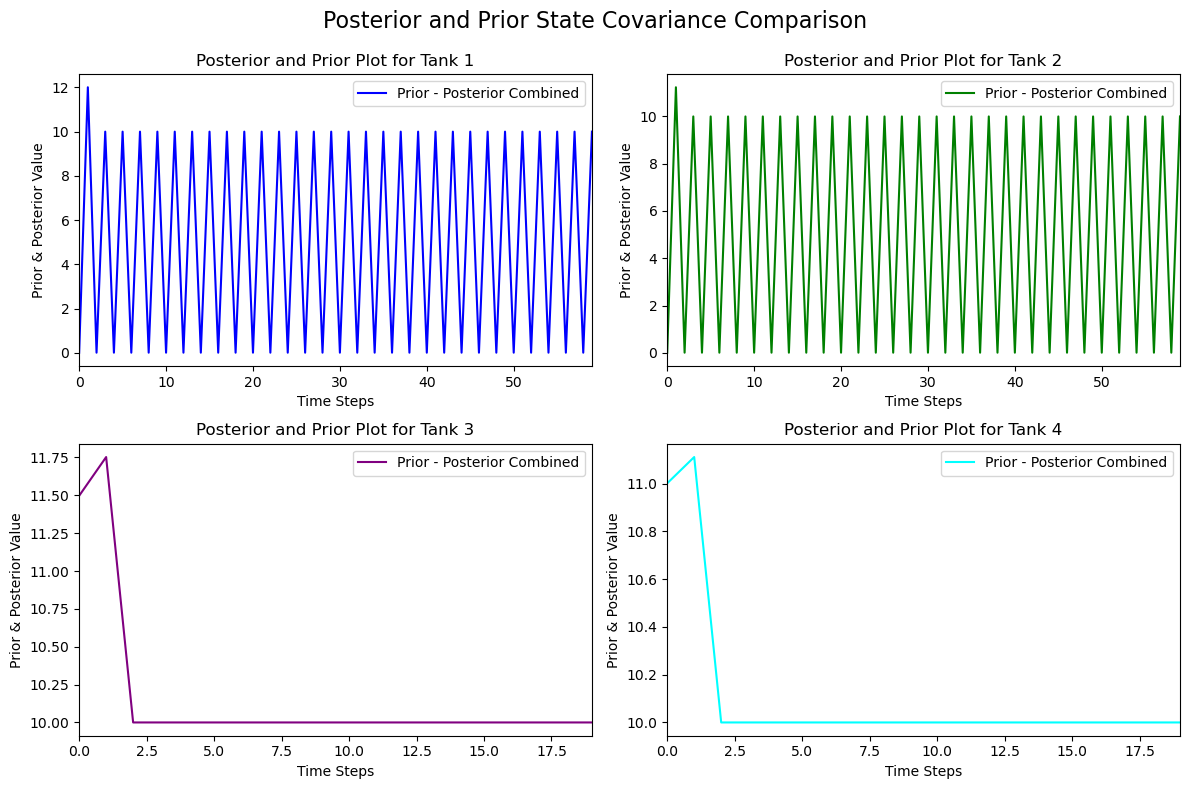

In [142]:
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior and Prior State Covariance Comparison', fontsize=16)

plot_data(1, P_posterior_store[:, 0][:30], P_prior_store[:, 0][:30], 'Tank 1', posterior_color='blue', prior_color='orange')
plot_data(2, P_posterior_store[:, 1][:30], P_prior_store[:, 1][:30], 'Tank 2', posterior_color='green', prior_color='red')
plot_data(3, P_posterior_store[:, 2][:10], P_prior_store[:, 2][:10], 'Tank 3', posterior_color='purple', prior_color='yellow')
plot_data(4, P_posterior_store[:, 3][:10], P_prior_store[:, 3][:10], 'Tank 4', posterior_color='cyan', prior_color='magenta')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Kalman Filter Result - 2nd Approach

In [69]:
# Create a dataframe with the results
results_dataframe = pd.DataFrame({
    'Time_Step': time_steps_10000,
    'Original_Tank1_Reading': tank1_measurements[:10000],
    'KalmanFilter_Tank1_Estimate': np.array(X_posterior_tank1),
    'Original_Tank2_Reading': tank2_measurements[:10000],
    'KalmanFilter_Tank2_Estimate': np.array(X_posterior_tank2),
    'Original_Tank3_Reading': tank3_measurements[:10000],
    'KalmanFilter_Tank3_Estimate': np.array(X_posterior_tank3),
    'Original_Tank4_Reading': tank4_measurements[:10000],
    'KalmanFilter_Tank4_Estimate': np.array(X_posterior_tank4),
})

# Display the dataframe
display(results_dataframe)


,Time_Step,Original_Tank1_Reading,KalmanFilter_Tank1_Estimate,Original_Tank2_Reading,KalmanFilter_Tank2_Estimate,Original_Tank3_Reading,KalmanFilter_Tank3_Estimate,Original_Tank4_Reading,KalmanFilter_Tank4_Estimate
0,0,12.400000,12.399994,12.700000,12.699888,1.800000,12.457848,1.400000,12.415416
1,1,12.404928,12.404956,12.700618,12.700641,1.792881,1.764271,1.400301,1.373577
2,2,12.409478,12.409489,12.701239,12.701248,1.786060,1.802188,1.400592,1.410694
3,3,12.413670,12.413681,12.701863,12.701872,1.779526,1.795469,1.400873,1.410858
4,4,12.417521,12.417531,12.702490,12.702498,1.773266,1.789213,1.401145,1.411136
...,...,...,...,...,...,...,...,...,...
9995,9995,12.262968,12.262978,12.783158,12.783167,1.633941,1.650105,1.409045,1.418789
9996,9996,12.262968,12.262978,12.783158,12.783167,1.633941,1.650105,1.409045,1.418789
9997,9997,12.262968,12.262978,12.783158,12.783167,1.633941,1.650105,1.409045,1.418789
9998,9998,12.262968,12.262978,12.783158,12.783167,1.633941,1.650105,1.409045,1.418789


#### Saving the compared data between Kalman filter estimates

In [70]:
results_dataframe.to_csv('Comparison_Kalman_Approach2.csv', sep=',', index=False, encoding='utf-8')

### **Conclusion of 2nd Approach:**

###### 1. Through a meticulous consideration of various units of measurement, our second approach, achieved exceptional accuracy in measuring each tank. By addressing the intricacies of unit conversions, we were able to effectively capture the true value of tank measurements. A notable aspect of this approach is the absence of off-diagonal terms in the process noise covariance matrix (Q), yet it yielded convergence within the Kalman filter.

###### 2. This accomplishment showcases the robustness and efficiency of our methodology in dealing with the complex dynamics of the system. These findings contribute significant advancements to the field of Kalman filter implementation. The implications of our work extend beyond this specific application, potentially benefiting a wide range of domains, including autonomous systems, control theory, and sensor fusion.

###### 3. These results highlight the potential for further exploration and experimentation, opening up new avenues for leveraging our approach to enhance various applications. As we continue to push the boundaries of knowledge, we anticipate that our work will pave the way for improved accuracy, reliability, and efficiency in state estimation and filtering techniques.

<h3 style='text-align: center;'>=======================End of Kalman Filter Implementation - Approach 2=======================</h3>